In [2]:
## Load packages and data
#library(dplyr)
library(tableone)
library(MatchIt)
library(Matching)
library(pROC)
library(ROCR)
library(ggplot2)
library(epitools)
library(plyr)
library(ipw)
library(sandwich)
library(survey)
library(reshape2)
library(ggplot2)
library(gridExtra)
library(xlsx)
library(optmatch)


In [3]:
#load data
kkh_data <- read.csv("pards_data_1107.csv")
#kkh_data <- read.csv("pards_data_0816.csv")
df<-data.frame(kkh_data)
kkh<-df[!is.na(df$d2_oi),]
kkh <- kkh[which(!((kkh$hfv==1)&(kkh$HFV_verify==0))), ]
#kkh <- kkh[which((kkh$Non_CPAP==1)), ]
####check column names
var<-colnames(kkh, do.NULL = FALSE)[1:9]
#head(kkh)

####select features
ID<-kkh$StudyID
hospital_number<-kkh$Hospital_number
female<-as.numeric(kkh$Gender=='Female')
age<-kkh$Age
pim2<-kkh$pim2
pelod<-kkh$pelod
p_bloodculture<-as.numeric(kkh$Positive_blood_culture=='Yes')
early_HFV<-kkh$early_HFV
D1_HFV<-kkh$D1_HFV
D2_HFV<-kkh$D2_HFV
D3_HFV<-kkh$D3_HFV
D4_HFV<-kkh$D4_HFV
D5_HFV<-kkh$D5_HFV
D6_HFV<-kkh$D6_HFV
D7_HFV<-kkh$D7_HFV
ICUadmissiondate <- as.Date(kkh$ICUadmissiondate,format="%d/%m/%Y")
ICUdischargedate <- as.Date(kkh$ICUdischargedate,format="%d/%m/%Y")


#comorbidity
comorbidity<-kkh$comorbidity
#risk factor of ARDS
rf_pneumonia<-as.numeric(kkh$PNEUMONIA=='Checked')
rf_sepsis<-as.numeric(kkh$SEPSIS=='Checked')
rf_aspiration<-as.numeric(kkh$ASPIRATION=='Checked')
rf_transfusion<-as.numeric(kkh$TRANSFUSION=='Checked')
rf_trauma<-as.numeric(kkh$TRAUMA=='Checked')
rf_drowning<-as.numeric(kkh$DROWNING=='Checked')

#other useful features
MODS<-as.numeric(kkh$MODS=='Yes')
OI<-kkh$d2_oi
OI_cat<-kkh$OI_category
treatment<-as.numeric(kkh$Received_HFV=='Yes')
died_in_ICU<-kkh$died_in_ICU
mortality_30day<-kkh$mort_30
mortality_28day<-kkh$mort_28
mortality_100day<-ifelse(kkh$Died.within.100.days=="Yes",1,0)
ventilation_free_day<-kkh$ventilation_free_day
picu_free_days<-kkh$picu_free_days
fio2<-kkh$avg_fio2max
map<-kkh$avg_mapmax
amplitude<-kkh$avg_amplitudemax


####prepare for the data
mydata<-cbind(ID,hospital_number,female,age,pim2,pelod,p_bloodculture,comorbidity,rf_pneumonia,rf_sepsis,rf_aspiration,rf_transfusion
              ,rf_trauma
              ,rf_drowning,MODS,OI
              ,treatment,died_in_ICU,D1_HFV,D2_HFV,D3_HFV,D4_HFV,D5_HFV,D6_HFV,D7_HFV,ICUadmissiondate,ICUdischargedate
              ,mortality_30day,mortality_28day,mortality_100day,ventilation_free_day,picu_free_days, fio2, map, amplitude,OI_cat)


mydata<-data.frame(mydata)
mydata$ICUduration<-mydata$ICUdischargedate-mydata$ICUadmissiondate+1
#mydata$OI_cat<-as.factor(mydata$OI_category)
#mydata$OI_cat<-C(mydata$OI_cat, contr.treatment, base=3)

head(mydata)

ID,hospital_number,female,age,pim2,pelod,p_bloodculture,comorbidity,rf_pneumonia,rf_sepsis,⋯,mortality_30day,mortality_28day,mortality_100day,ventilation_free_day,picu_free_days,fio2,map,amplitude,OI_cat,ICUduration
1001,1,1,0.02,87.3,42,1,0,0,1,⋯,1,1,1,0,0,NA,NA,NA,1,3
1003,1,0,0.47,2.8,11,0,0,1,0,⋯,0,0,0,21,26,NA,NA,NA,1,3
1005,1,1,0.10,0.6,1,0,0,1,0,⋯,0,0,0,21,20,NA,NA,NA,2,9
1006,1,1,1.72,8.2,12,0,0,1,0,⋯,0,0,0,7,0,100,23,70.00000,4,59
1008,1,1,2.92,6.8,2,0,1,1,0,⋯,0,0,0,27,24,NA,NA,NA,1,5
1009,1,0,0.70,2.8,10,0,1,1,0,⋯,1,1,1,0,0,100,32,43.66667,1,9


In [5]:
#create new dataset for cox ph model with time-dependent adjustment for treatment and covariates
#df2 is the final dataset
df<-melt(mydata,id.vars=c("ID","hospital_number","ICUduration","died_in_ICU","mortality_30day","mortality_28day","mortality_100day","treatment",
                          "female","age","pim2","pelod","p_bloodculture",
                          "comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration","rf_transfusion", 
                          "rf_trauma", "rf_drowning","MODS","OI","OI_cat"), 
         measure.vars=c("D1_HFV","D2_HFV","D3_HFV","D4_HFV","D5_HFV","D6_HFV","D7_HFV"),
         variable.name = "end_day",value.name = "HFV_indicator",factorsAsStrings = FALSE)

df<-df[order(df$ID), , drop = FALSE]
df$end_day<-revalue(df$end_day, c("D1_HFV"=1,"D2_HFV"=2, "D3_HFV"=3,"D4_HFV"=4,"D5_HFV"=5, "D6_HFV"=6,"D7_HFV"=7))
df$end_day<-as.numeric(df$end_day)
df$start_day<-df$end_day-1

df1<-df[df$start_day<df$ICUduration,]
df1$event<-ifelse(df1$end_day<df1$ICUduration, 0,df1$died_in_ICU)

df1 <- df1[c("treatment","ID","hospital_number","start_day","end_day","HFV_indicator","event","died_in_ICU","mortality_28day","ICUduration","female","age","pim2","pelod","p_bloodculture","comorbidity","rf_pneumonia"
         ,"rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma", "rf_drowning","MODS","OI","OI_cat")]


length(df1$ID)
df2 <- do.call("rbind", lapply(unique(df1$ID), function(id) {
    df1_id <- df1[df1$ID == id, ]
    n_id <- nrow(df1_id)
    n_all <- df1_id$ICUduration[1]
    if(n_all>7){
        n_all<-7
    }
    if (n_id == n_all) {
        df1_id
    } else {
        last_row <- df1_id[n_id, ]
        df1_add <- do.call("rbind", lapply((n_id + 1):n_all, function(r) {
            new_row <- last_row
            new_row$start_day <- r - 1
            new_row$end_day <- r
            new_row$HFV_indicator<-0
            if(r==n_all){
                new_row$event<- new_row$mortality_28day
            } else{
                new_row$event<- 0
            }
            new_row
        }))
        rbind(df1_id, df1_add)
    }
}))
#head(df2)
df2[1:20,]


[1] 2162

,treatment,ID,hospital_number,start_day,end_day,HFV_indicator,event,died_in_ICU,mortality_28day,ICUduration,⋯,comorbidity,rf_pneumonia,rf_sepsis,rf_aspiration,rf_transfusion,rf_trauma,rf_drowning,MODS,OI,OI_cat
1,0,1001,1,0,1,0,0,1,1,3,⋯,0,0,1,0,0,0,0,1,5.06,1
329,0,1001,1,1,2,0,0,1,1,3,⋯,0,0,1,0,0,0,0,1,5.06,1
657,0,1001,1,2,3,0,1,1,1,3,⋯,0,0,1,0,0,0,0,1,5.06,1
2,0,1003,1,0,1,0,0,0,0,3,⋯,0,1,0,0,0,0,0,0,5.11,1
330,0,1003,1,1,2,0,0,0,0,3,⋯,0,1,0,0,0,0,0,0,5.11,1
658,0,1003,1,2,3,0,0,0,0,3,⋯,0,1,0,0,0,0,0,0,5.11,1
3,0,1005,1,0,1,0,0,0,0,9,⋯,0,1,0,0,0,0,0,0,8.01,2
331,0,1005,1,1,2,0,0,0,0,9,⋯,0,1,0,0,0,0,0,0,8.01,2
659,0,1005,1,2,3,0,0,0,0,9,⋯,0,1,0,0,0,0,0,0,8.01,2
987,0,1005,1,3,4,0,0,0,0,9,⋯,0,1,0,0,0,0,0,0,8.01,2


# GenMatch with Matching package

In [6]:

force_exact<-c(rep(0, 13),1)
var_list<-c("age","pim2","pelod","female","p_bloodculture","comorbidity","MODS","rf_pneumonia",'rf_sepsis','rf_aspiration',
            'rf_transfusion','rf_trauma','rf_drowning',"OI")
var_list2<-c("age","pim2","pelod","female","p_bloodculture","comorbidity","MODS","rf_pneumonia",'rf_sepsis','rf_aspiration',
            'rf_transfusion','rf_trauma','rf_drowning',"OI_cat")
treatment<-data.frame(mydata[,"treatment"])
#mydata_wth_pscore<-data.frame(cbind(mydata[, var_list,pscore]))
gen_data<-data.frame(mydata[, var_list])
#mydata_wth_pscore$female<-as.factor(mydata_wth_pscore$female)

# treatment~age+pim2+pelod+factor(female)+factor(p_bloodculture)+factor(comorbidity)+factor(rf_pneumonia)+factor(rf_sepsis)
#                  +factor(rf_aspiration)+factor(rf_transfusion)+factor(rf_trauma)+factor(rf_drowning)+factor(MODS)+factor(OI_cat)
gen.out<-GenMatch(mydata$treatment,mydata[,var_list], pop.size=328,replace=FALSE,exact=force_exact,distance.tolerance=4.0,print.level=0)
gen_treat_data<-gen_data
gen_treat_data$treatment<-mydata[,"treatment"]



Loading required namespace: rgenoud


In [7]:
m.out<-Match(Tr=gen_treat_data$treatment, X=gen_treat_data[,var_list], estimand = "ATT", M = 1,
             exact =force_exact,distance.tolerance=3.0, caliper = NULL, replace=TRUE, ties=FALSE,
             Weight.matrix = gen.out
            )
summary(m.out)


Estimate...  0 
SE.........  0 
T-stat.....  NaN 
p.val......  NA 

Original number of observations..............  328 
Original number of treated obs...............  122 
Matched number of observations...............  118 
Matched number of observations  (unweighted).  118 

Number of obs dropped by 'exact' or 'caliper'  4 



In [8]:
mydata$mort_100day<-ifelse(kkh$Died.within.100.days=="Yes",1,0)

matchedID_hfv<-mydata[m.out$index.treated,"ID"]
matchedID_non_hfv<-mydata[m.out$index.control,"ID"]
hfv<-mydata[match(matchedID_hfv,mydata$ID),]
non_hfv<-mydata[match(matchedID_non_hfv,mydata$ID),]


#paired t-test for ventilator free days
diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
t.test(diffy)
#paired t-test for picu free days
diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
t.test(diffy1)

#McNemar test for 100 day mortality
mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

#calculate n% of 100 day mortality for matched cohort
print("Non-HFOV group 100day mortality n:")
length(non_hfv$ID[non_hfv$mort_100day==1])
print("%:")
length(non_hfv$ID[non_hfv$mort_100day==1])/length(matchedID_hfv)
print("HFOV group 100day mortality n:")
length(hfv$ID[hfv$mort_100day==1])
print("%:")
length(hfv$ID[hfv$mort_100day==1])/length(matchedID_hfv)

#calculate n% of 28 day mortality for matched cohort
print("Non-HFOV group 28day mortality n:")
length(non_hfv$ID[non_hfv$mortality_28day==1])
print("%:")
length(non_hfv$ID[non_hfv$mortality_28day==1])/length(matchedID_hfv)
print("HFOV group 28day mortality n:")
length(hfv$ID[hfv$mortality_28day==1])
print("%:")
length(hfv$ID[hfv$mortality_28day==1])/length(matchedID_hfv)

#McNemar test for 28-day mortality
#y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
#y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
#table(y_treatment,y_control)
mcnemar.test(hfv$mortality_28day, non_hfv$mortality_28day)

#calculate odds ratio for 28-day mortality
#y_treatment<-data$mortality_28day[data$treatment==1] 
#y_control<-data$mortality_28day[data$treatment==0] 

#calculate odds ratio for ICU mortality
#y_treatment<-hfv[died_in_ICU] 
#y_control<-non_hfv$died_in_ICU

########## calculate Odd's ratio here!
########## calculate Odd's ratio here!
a<-sum(hfv$mortality_28day)
b<-sum(non_hfv$mortality_28day)
c<-sum(hfv$mortality_28day==0)
d<-sum(non_hfv$mortality_28day==0)
# c<-length(hfv[hfv$died_in_ICU==0,1])
# d<-length(non_hfv[non_hfv$died_in_ICU==0,1])
 print(c(a,b,c,d))
 a/(a+c)
 b/(b+d)
 oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

#Table1 for matching pairs

PSmatching_data<-rbind(hfv,non_hfv)
#PSmatching_data<-read.csv("PS_matching_data_significant_result.csv")
head(PSmatching_data)


xvars<-c("female","age","pim2","pelod","p_bloodculture","MODS","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning",
         "OI","OI_cat","ventilation_free_day","picu_free_days","mortality_28day","mort_100day","died_in_ICU")
catvars<-c("female","p_bloodculture","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", 
           "rf_drowning","rf_trauma","MODS","OI_cat","mortality_28day","mort_100day","died_in_ICU")


TableOne_daily<-CreateTableOne(var = xvars, factorVars =catvars,strata ="treatment", data=PSmatching_data)

print(TableOne_daily, nonnormal = c("age","pim2","pelod","OI","ventilation_free_day","picu_free_days"), contDigits = 1, catDigits = 1, pDigits = 4, smd = TRUE,testName=TRUE)
#non parametric KruskalWalli test for PICU free days


	One Sample t-test

data:  diffy
t = -1.239, df = 117, p-value = 0.2178
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -3.5673768  0.8216141
sample estimates:
mean of x 
-1.372881 



	One Sample t-test

data:  diffy1
t = -2.1615, df = 117, p-value = 0.03269
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -4.141030 -0.181004
sample estimates:
mean of x 
-2.161017 



	McNemar's Chi-squared test with continuity correction

data:  hfv$mort_100day and non_hfv$mort_100day
McNemar's chi-squared = 0.078431, df = 1, p-value = 0.7794


[1] "Non-HFOV group 100day mortality n:"


[1] 51

[1] "%:"


[1] 0.4322034

[1] "HFOV group 100day mortality n:"


[1] 54

[1] "%:"


[1] 0.4576271

[1] "Non-HFOV group 28day mortality n:"


[1] 21

[1] "%:"


[1] 0.1779661

[1] "HFOV group 28day mortality n:"


[1] 38

[1] "%:"


[1] 0.3220339


	McNemar's Chi-squared test with continuity correction

data:  hfv$mortality_28day and non_hfv$mortality_28day
McNemar's chi-squared = 5.6889, df = 1, p-value = 0.01707


[1] 38 21 80 97


[1] 0.3220339

[1] 0.1779661

,Disease1,Disease2,Total
Exposed1,38,80,118
Exposed2,21,97,118
Total,59,177,236
,estimate,lower,upper
Exposed1,1.000000,NA,NA
Exposed2,2.180742,1.192347,4.077767
,midp.exact,fisher.exact,chi.square
Exposed1,NA,NA,NA
Exposed2,0.01112853,0.01573759,0.0106006


,ID,hospital_number,female,age,pim2,pelod,p_bloodculture,comorbidity,rf_pneumonia,rf_sepsis,⋯,mortality_28day,mortality_100day,ventilation_free_day,picu_free_days,fio2,map,amplitude,OI_cat,ICUduration,mort_100day
4,1006,1,1,1.72,8.2,12,0,0,1,0,⋯,0,0,7,0,100.00,23.0,70.00000,4,59,0
6,1009,1,0,0.70,2.8,10,0,1,1,0,⋯,1,1,0,0,100.00,32.0,43.66667,1,9,1
8,1011,1,1,1.31,27.6,1,1,1,1,0,⋯,0,0,0,0,100.00,30.0,75.00000,4,61,0
18,1022,1,1,0.28,9.0,20,0,1,1,0,⋯,0,0,16,15,58.75,28.0,50.00000,2,14,0
20,1024,1,0,5.34,75.6,41,1,1,1,0,⋯,1,1,0,0,100.00,25.5,62.00000,1,3,1
27,1037,1,1,0.28,8.9,20,0,1,1,0,⋯,0,0,16,15,67.00,28.0,53.00000,2,14,0


                                     Stratified by treatment
                                      0                 1                
  n                                    118               118             
  female = 1 (%)                        60 ( 50.8)        63 ( 53.4)     
  age (median [IQR])                   2.0 [0.8, 5.8]    2.3 [0.8, 5.5]  
  pim2 (median [IQR])                  9.4 [4.1, 18.2]   8.0 [4.7, 27.6] 
  pelod (median [IQR])                10.5 [1.0, 13.8]  10.0 [1.2, 16.0] 
  p_bloodculture = 1 (%)                22 ( 18.6)        21 ( 17.8)     
  MODS = 1 (%)                          54 ( 45.8)        54 ( 45.8)     
  comorbidity = 1 (%)                   66 ( 55.9)        66 ( 55.9)     
  rf_pneumonia = 1 (%)                 100 ( 84.7)       102 ( 86.4)     
  rf_sepsis = 1 (%)                     43 ( 36.4)        32 ( 27.1)     
  rf_aspiration = 1 (%)                  5 (  4.2)         4 (  3.4)     
  rf_transfusion = 1 (%)                 1 (  0.8) 

## Subgroup Analysis

In [ ]:
####################################################
#Subgroup Analysis: Drop one out method on daily matching
####################################################
#unique(mydata$hospital_number)

############### Drop hospital 1 out from data ##############





var_list<-c("age","pim2","pelod","female","p_bloodculture","comorbidity","MODS","rf_pneumonia",'rf_sepsis','rf_aspiration',
            'rf_transfusion','rf_trauma','rf_drowning',"OI")


gen_treat_data<-data.frame(mydata)
df_not<-gen_treat_data[gen_treat_data$hospital_number!=1,]
pop_size<-length(df_not[,1])
#str(gen_treat_data)
force_exact<-c(rep(0, 13),1)
gen.out<-GenMatch(Tr=df_not$treatment,X=df_not[,var_list], pop.size=pop_size,replace=FALSE,exact=force_exact,distance.tolerance=5.0,print.level=0)
m.out<-Match(Tr=df_not$treatment, X=df_not[,var_list], estimand = "ATT", M = 1,
             exact =force_exact,distance.tolerance=5.0, caliper = NULL, replace=TRUE, ties=FALSE,
             Weight.matrix = gen.out
            )
summary(m.out)

matchedID_hfv<-df_not[m.out$index.treated,"ID"]
matchedID_non_hfv<-df_not[m.out$index.control,"ID"]
hfv<-df_not[match(matchedID_hfv,df_not$ID),]
non_hfv<-df_not[match(matchedID_non_hfv,df_not$ID),]


#paired t-test for ventilator free days
diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
t.test(diffy)
#paired t-test for picu free days
diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
t.test(diffy1)

#McNemar test for 100 day mortality
mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

#calculate n% of 100 day mortality for matched cohort
print("Non-HFOV group 100day mortality n:")
length(non_hfv$ID[non_hfv$mort_100day==1])
print("%:")
length(non_hfv$ID[non_hfv$mort_100day==1])/length(matchedID_hfv)
print("HFOV group 100day mortality n:")
length(hfv$ID[hfv$mort_100day==1])
print("%:")
length(hfv$ID[hfv$mort_100day==1])/length(matchedID_hfv)

#calculate n% of 28 day mortality for matched cohort
print("Non-HFOV group 28day mortality n:")
length(non_hfv$ID[non_hfv$mortality_28day==1])
print("%:")
length(non_hfv$ID[non_hfv$mortality_28day==1])/length(matchedID_hfv)
print("HFOV group 28day mortality n:")
length(hfv$ID[hfv$mortality_28day==1])
print("%:")
length(hfv$ID[hfv$mortality_28day==1])/length(matchedID_hfv)

#McNemar test for 28-day mortality
#y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
#y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
#table(y_treatment,y_control)
mcnemar.test(hfv$mortality_28day, non_hfv$mortality_28day)

#calculate odds ratio for 28-day mortality
########## calculate Odd's ratio here!
a<-sum(hfv$mortality_28day==1)
b<-sum(non_hfv$mortality_28day==1)
c<-sum(hfv$mortality_28day==0)
d<-sum(non_hfv$mortality_28day==0)
# c<-length(hfv[hfv$died_in_ICU==0,1])
# d<-length(non_hfv[non_hfv$died_in_ICU==0,1])
print(c(a,b,c,d))
a/(a+c)
b/(b+d)
oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

#Table1 for matching pairs

PSmatching_data<-rbind(hfv,non_hfv)
#PSmatching_data<-read.csv("PS_matching_data_significant_result.csv")
head(PSmatching_data)


xvars<-c("female","age","pim2","pelod","p_bloodculture","MODS","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning",
         "OI","OI_cat","ventilation_free_day","picu_free_days","mortality_28day","mort_100day","died_in_ICU")
catvars<-c("female","p_bloodculture","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", 
           "rf_drowning","rf_trauma","MODS","OI_cat","mortality_28day","mort_100day","died_in_ICU")


TableOne_daily<-CreateTableOne(var = xvars, factorVars =catvars,strata ="treatment", data=PSmatching_data)

print(TableOne_daily, nonnormal = c("age","pim2","pelod","OI","ventilation_free_day","picu_free_days"), contDigits = 1, catDigits = 1, pDigits = 4, smd = TRUE,testName=TRUE)
#non parametric KruskalWalli test for PICU free days


In [ ]:
####################################################
#Subgroup Analysis: Drop one out method on daily matching
####################################################
#unique(mydata$hospital_number)

############### Drop hospital 2 out from data ##############





var_list<-c("age","pim2","pelod","female","p_bloodculture","comorbidity","MODS","rf_pneumonia",'rf_sepsis','rf_aspiration',
            'rf_transfusion','rf_trauma','rf_drowning',"OI")


gen_treat_data<-data.frame(mydata)
df_not<-gen_treat_data[gen_treat_data$hospital_number!=2,]
pop_size<-length(df_not[,1])
#str(gen_treat_data)
force_exact<-c(rep(0, 13),1)
gen.out<-GenMatch(Tr=df_not$treatment,X=df_not[,var_list], pop.size=pop_size,replace=FALSE,exact=force_exact,distance.tolerance=5.0,print.level=0)
m.out<-Match(Tr=df_not$treatment, X=df_not[,var_list], estimand = "ATT", M = 1,
             exact =force_exact,distance.tolerance=5.0, caliper = NULL, replace=TRUE, ties=FALSE,
             Weight.matrix = gen.out
            )
summary(m.out)

matchedID_hfv<-df_not[m.out$index.treated,"ID"]
matchedID_non_hfv<-df_not[m.out$index.control,"ID"]
hfv<-df_not[match(matchedID_hfv,df_not$ID),]
non_hfv<-df_not[match(matchedID_non_hfv,df_not$ID),]


#paired t-test for ventilator free days
diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
t.test(diffy)
#paired t-test for picu free days
diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
t.test(diffy1)

#McNemar test for 100 day mortality
mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

#calculate n% of 100 day mortality for matched cohort
print("Non-HFOV group 100day mortality n:")
length(non_hfv$ID[non_hfv$mort_100day==1])
print("%:")
length(non_hfv$ID[non_hfv$mort_100day==1])/length(matchedID_hfv)
print("HFOV group 100day mortality n:")
length(hfv$ID[hfv$mort_100day==1])
print("%:")
length(hfv$ID[hfv$mort_100day==1])/length(matchedID_hfv)

#calculate n% of 28 day mortality for matched cohort
print("Non-HFOV group 28day mortality n:")
length(non_hfv$ID[non_hfv$mortality_28day==1])
print("%:")
length(non_hfv$ID[non_hfv$mortality_28day==1])/length(matchedID_hfv)
print("HFOV group 28day mortality n:")
length(hfv$ID[hfv$mortality_28day==1])
print("%:")
length(hfv$ID[hfv$mortality_28day==1])/length(matchedID_hfv)

#McNemar test for 28-day mortality
#y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
#y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
#table(y_treatment,y_control)
mcnemar.test(hfv$mortality_28day, non_hfv$mortality_28day)

#calculate odds ratio for 28-day mortality
########## calculate Odd's ratio here!
a<-sum(hfv$mortality_28day==1)
b<-sum(non_hfv$mortality_28day==1)
c<-sum(hfv$mortality_28day==0)
d<-sum(non_hfv$mortality_28day==0)
# c<-length(hfv[hfv$died_in_ICU==0,1])
# d<-length(non_hfv[non_hfv$died_in_ICU==0,1])
print(c(a,b,c,d))
a/(a+c)
b/(b+d)
oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

#Table1 for matching pairs

PSmatching_data<-rbind(hfv,non_hfv)
#PSmatching_data<-read.csv("PS_matching_data_significant_result.csv")
head(PSmatching_data)


xvars<-c("female","age","pim2","pelod","p_bloodculture","MODS","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning",
         "OI","OI_cat","ventilation_free_day","picu_free_days","mortality_28day","mort_100day","died_in_ICU")
catvars<-c("female","p_bloodculture","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", 
           "rf_drowning","rf_trauma","MODS","OI_cat","mortality_28day","mort_100day","died_in_ICU")


TableOne_daily<-CreateTableOne(var = xvars, factorVars =catvars,strata ="treatment", data=PSmatching_data)

print(TableOne_daily, nonnormal = c("age","pim2","pelod","OI","ventilation_free_day","picu_free_days"), contDigits = 1, catDigits = 1, pDigits = 4, smd = TRUE,testName=TRUE)
#non parametric KruskalWalli test for PICU free days


In [ ]:
####################################################
#Subgroup Analysis: Drop one out method on daily matching
####################################################
#unique(mydata$hospital_number)

############### Drop hospital 3 out from data ##############





var_list<-c("age","pim2","pelod","female","p_bloodculture","comorbidity","MODS","rf_pneumonia",'rf_sepsis','rf_aspiration',
            'rf_transfusion','rf_trauma','rf_drowning',"OI")


gen_treat_data<-data.frame(mydata)
df_not<-gen_treat_data[gen_treat_data$hospital_number!=3,]
pop_size<-length(df_not[,1])
#str(gen_treat_data)
force_exact<-c(rep(0, 13),1)
gen.out<-GenMatch(Tr=df_not$treatment,X=df_not[,var_list], pop.size=pop_size,replace=FALSE,exact=force_exact,distance.tolerance=5.0,print.level=0)
m.out<-Match(Tr=df_not$treatment, X=df_not[,var_list], estimand = "ATT", M = 1,
             exact =force_exact,distance.tolerance=5.0, caliper = NULL, replace=TRUE, ties=FALSE,
             Weight.matrix = gen.out
            )
summary(m.out)

matchedID_hfv<-df_not[m.out$index.treated,"ID"]
matchedID_non_hfv<-df_not[m.out$index.control,"ID"]
hfv<-df_not[match(matchedID_hfv,df_not$ID),]
non_hfv<-df_not[match(matchedID_non_hfv,df_not$ID),]


#paired t-test for ventilator free days
diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
t.test(diffy)
#paired t-test for picu free days
diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
t.test(diffy1)

#McNemar test for 100 day mortality
mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

#calculate n% of 100 day mortality for matched cohort
print("Non-HFOV group 100day mortality n:")
length(non_hfv$ID[non_hfv$mort_100day==1])
print("%:")
length(non_hfv$ID[non_hfv$mort_100day==1])/length(matchedID_hfv)
print("HFOV group 100day mortality n:")
length(hfv$ID[hfv$mort_100day==1])
print("%:")
length(hfv$ID[hfv$mort_100day==1])/length(matchedID_hfv)

#calculate n% of 28 day mortality for matched cohort
print("Non-HFOV group 28day mortality n:")
length(non_hfv$ID[non_hfv$mortality_28day==1])
print("%:")
length(non_hfv$ID[non_hfv$mortality_28day==1])/length(matchedID_hfv)
print("HFOV group 28day mortality n:")
length(hfv$ID[hfv$mortality_28day==1])
print("%:")
length(hfv$ID[hfv$mortality_28day==1])/length(matchedID_hfv)

#McNemar test for 28-day mortality
#y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
#y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
#table(y_treatment,y_control)
mcnemar.test(hfv$mortality_28day, non_hfv$mortality_28day)

#calculate odds ratio for 28-day mortality
########## calculate Odd's ratio here!
a<-sum(hfv$mortality_28day==1)
b<-sum(non_hfv$mortality_28day==1)
c<-sum(hfv$mortality_28day==0)
d<-sum(non_hfv$mortality_28day==0)
# c<-length(hfv[hfv$died_in_ICU==0,1])
# d<-length(non_hfv[non_hfv$died_in_ICU==0,1])
print(c(a,b,c,d))
a/(a+c)
b/(b+d)
oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

#Table1 for matching pairs

PSmatching_data<-rbind(hfv,non_hfv)
#PSmatching_data<-read.csv("PS_matching_data_significant_result.csv")
head(PSmatching_data)


xvars<-c("female","age","pim2","pelod","p_bloodculture","MODS","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning",
         "OI","OI_cat","ventilation_free_day","picu_free_days","mortality_28day","mort_100day","died_in_ICU")
catvars<-c("female","p_bloodculture","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", 
           "rf_drowning","rf_trauma","MODS","OI_cat","mortality_28day","mort_100day","died_in_ICU")


TableOne_daily<-CreateTableOne(var = xvars, factorVars =catvars,strata ="treatment", data=PSmatching_data)

print(TableOne_daily, nonnormal = c("age","pim2","pelod","OI","ventilation_free_day","picu_free_days"), contDigits = 1, catDigits = 1, pDigits = 4, smd = TRUE,testName=TRUE)
#non parametric KruskalWalli test for PICU free days


In [ ]:
####################################################
#Subgroup Analysis: Drop one out method on daily matching
####################################################
#unique(mydata$hospital_number)

############### Drop hospital 4 out from data ##############





var_list<-c("age","pim2","pelod","female","p_bloodculture","comorbidity","MODS","rf_pneumonia",'rf_sepsis','rf_aspiration',
            'rf_transfusion','rf_trauma','rf_drowning',"OI")


gen_treat_data<-data.frame(mydata)
df_not<-gen_treat_data[gen_treat_data$hospital_number!=4,]
pop_size<-length(df_not[,1])
#str(gen_treat_data)
force_exact<-c(rep(0, 13),1)
gen.out<-GenMatch(Tr=df_not$treatment,X=df_not[,var_list], pop.size=pop_size,replace=FALSE,exact=force_exact,distance.tolerance=5.0,print.level=0)
m.out<-Match(Tr=df_not$treatment, X=df_not[,var_list], estimand = "ATT", M = 1,
             exact =force_exact,distance.tolerance=5.0, caliper = NULL, replace=TRUE, ties=FALSE,
             Weight.matrix = gen.out
            )
summary(m.out)

matchedID_hfv<-df_not[m.out$index.treated,"ID"]
matchedID_non_hfv<-df_not[m.out$index.control,"ID"]
hfv<-df_not[match(matchedID_hfv,df_not$ID),]
non_hfv<-df_not[match(matchedID_non_hfv,df_not$ID),]


#paired t-test for ventilator free days
diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
t.test(diffy)
#paired t-test for picu free days
diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
t.test(diffy1)

#McNemar test for 100 day mortality
mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

#calculate n% of 100 day mortality for matched cohort
print("Non-HFOV group 100day mortality n:")
length(non_hfv$ID[non_hfv$mort_100day==1])
print("%:")
length(non_hfv$ID[non_hfv$mort_100day==1])/length(matchedID_hfv)
print("HFOV group 100day mortality n:")
length(hfv$ID[hfv$mort_100day==1])
print("%:")
length(hfv$ID[hfv$mort_100day==1])/length(matchedID_hfv)

#calculate n% of 28 day mortality for matched cohort
print("Non-HFOV group 28day mortality n:")
length(non_hfv$ID[non_hfv$mortality_28day==1])
print("%:")
length(non_hfv$ID[non_hfv$mortality_28day==1])/length(matchedID_hfv)
print("HFOV group 28day mortality n:")
length(hfv$ID[hfv$mortality_28day==1])
print("%:")
length(hfv$ID[hfv$mortality_28day==1])/length(matchedID_hfv)

#McNemar test for 28-day mortality
#y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
#y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
#table(y_treatment,y_control)
mcnemar.test(hfv$mortality_28day, non_hfv$mortality_28day)

#calculate odds ratio for 28-day mortality
########## calculate Odd's ratio here!
a<-sum(hfv$mortality_28day==1)
b<-sum(non_hfv$mortality_28day==1)
c<-sum(hfv$mortality_28day==0)
d<-sum(non_hfv$mortality_28day==0)
# c<-length(hfv[hfv$died_in_ICU==0,1])
# d<-length(non_hfv[non_hfv$died_in_ICU==0,1])
print(c(a,b,c,d))
a/(a+c)
b/(b+d)
oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

#Table1 for matching pairs

PSmatching_data<-rbind(hfv,non_hfv)
#PSmatching_data<-read.csv("PS_matching_data_significant_result.csv")
head(PSmatching_data)


xvars<-c("female","age","pim2","pelod","p_bloodculture","MODS","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning",
         "OI","OI_cat","ventilation_free_day","picu_free_days","mortality_28day","mort_100day","died_in_ICU")
catvars<-c("female","p_bloodculture","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", 
           "rf_drowning","rf_trauma","MODS","OI_cat","mortality_28day","mort_100day","died_in_ICU")


TableOne_daily<-CreateTableOne(var = xvars, factorVars =catvars,strata ="treatment", data=PSmatching_data)

print(TableOne_daily, nonnormal = c("age","pim2","pelod","OI","ventilation_free_day","picu_free_days"), contDigits = 1, catDigits = 1, pDigits = 4, smd = TRUE,testName=TRUE)
#non parametric KruskalWalli test for PICU free days


In [ ]:
####################################################
#Subgroup Analysis: Drop one out method on daily matching
####################################################
#unique(mydata$hospital_number)

############### Drop hospital 6 out from data ##############





var_list<-c("age","pim2","pelod","female","p_bloodculture","comorbidity","MODS","rf_pneumonia",'rf_sepsis','rf_aspiration',
            'rf_transfusion','rf_trauma','rf_drowning',"OI")


gen_treat_data<-data.frame(mydata)
df_not<-gen_treat_data[gen_treat_data$hospital_number!=6,]
pop_size<-length(df_not[,1])
#str(gen_treat_data)
force_exact<-c(rep(0, 13),1)
gen.out<-GenMatch(Tr=df_not$treatment,X=df_not[,var_list], pop.size=pop_size,replace=FALSE,exact=force_exact,distance.tolerance=4.0,print.level=0)
m.out<-Match(Tr=df_not$treatment, X=df_not[,var_list], estimand = "ATT", M = 1,
             exact =force_exact,distance.tolerance=4.0, caliper = NULL, replace=TRUE, ties=FALSE,
             Weight.matrix = gen.out
            )
summary(m.out)

matchedID_hfv<-df_not[m.out$index.treated,"ID"]
matchedID_non_hfv<-df_not[m.out$index.control,"ID"]
hfv<-df_not[match(matchedID_hfv,df_not$ID),]
non_hfv<-df_not[match(matchedID_non_hfv,df_not$ID),]


#paired t-test for ventilator free days
diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
t.test(diffy)
#paired t-test for picu free days
diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
t.test(diffy1)

#McNemar test for 100 day mortality
mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

#calculate n% of 100 day mortality for matched cohort
print("Non-HFOV group 100day mortality n:")
length(non_hfv$ID[non_hfv$mort_100day==1])
print("%:")
length(non_hfv$ID[non_hfv$mort_100day==1])/length(matchedID_hfv)
print("HFOV group 100day mortality n:")
length(hfv$ID[hfv$mort_100day==1])
print("%:")
length(hfv$ID[hfv$mort_100day==1])/length(matchedID_hfv)

#calculate n% of 28 day mortality for matched cohort
print("Non-HFOV group 28day mortality n:")
length(non_hfv$ID[non_hfv$mortality_28day==1])
print("%:")
length(non_hfv$ID[non_hfv$mortality_28day==1])/length(matchedID_hfv)
print("HFOV group 28day mortality n:")
length(hfv$ID[hfv$mortality_28day==1])
print("%:")
length(hfv$ID[hfv$mortality_28day==1])/length(matchedID_hfv)

#McNemar test for 28-day mortality
#y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
#y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
#table(y_treatment,y_control)
mcnemar.test(hfv$mortality_28day, non_hfv$mortality_28day)

#calculate odds ratio for 28-day mortality
########## calculate Odd's ratio here!
a<-sum(hfv$mortality_28day==1)
b<-sum(non_hfv$mortality_28day==1)
c<-sum(hfv$mortality_28day==0)
d<-sum(non_hfv$mortality_28day==0)
# c<-length(hfv[hfv$died_in_ICU==0,1])
# d<-length(non_hfv[non_hfv$died_in_ICU==0,1])
print(c(a,b,c,d))
a/(a+c)
b/(b+d)
oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

#Table1 for matching pairs

PSmatching_data<-rbind(hfv,non_hfv)
#PSmatching_data<-read.csv("PS_matching_data_significant_result.csv")
head(PSmatching_data)


xvars<-c("female","age","pim2","pelod","p_bloodculture","MODS","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning",
         "OI","OI_cat","ventilation_free_day","picu_free_days","mortality_28day","mort_100day","died_in_ICU")
catvars<-c("female","p_bloodculture","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", 
           "rf_drowning","rf_trauma","MODS","OI_cat","mortality_28day","mort_100day","died_in_ICU")


TableOne_daily<-CreateTableOne(var = xvars, factorVars =catvars,strata ="treatment", data=PSmatching_data)

print(TableOne_daily, nonnormal = c("age","pim2","pelod","OI","ventilation_free_day","picu_free_days"), contDigits = 1, catDigits = 1, pDigits = 4, smd = TRUE,testName=TRUE)
#non parametric KruskalWalli test for PICU free days


In [ ]:
####################################################
#Subgroup Analysis: Drop one out method on daily matching
####################################################
#unique(mydata$hospital_number)

############### Drop hospital 6 out from data ##############





var_list<-c("age","pim2","pelod","female","p_bloodculture","comorbidity","MODS","rf_pneumonia",'rf_sepsis','rf_aspiration',
            'rf_transfusion','rf_trauma','rf_drowning',"OI")


gen_treat_data<-data.frame(mydata)
df_not<-gen_treat_data[gen_treat_data$hospital_number!=6,]
pop_size<-length(df_not[,1])
#str(gen_treat_data)
force_exact<-c(rep(0, 13),1)
gen.out<-GenMatch(Tr=df_not$treatment,X=df_not[,var_list], pop.size=pop_size,replace=FALSE,exact=force_exact,distance.tolerance=4.0,print.level=0)
m.out<-Match(Tr=df_not$treatment, X=df_not[,var_list], estimand = "ATT", M = 1,
             exact =force_exact,distance.tolerance=4.0, caliper = NULL, replace=TRUE, ties=FALSE,
             Weight.matrix = gen.out
            )
summary(m.out)

matchedID_hfv<-df_not[m.out$index.treated,"ID"]
matchedID_non_hfv<-df_not[m.out$index.control,"ID"]
hfv<-df_not[match(matchedID_hfv,df_not$ID),]
non_hfv<-df_not[match(matchedID_non_hfv,df_not$ID),]


#paired t-test for ventilator free days
diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
t.test(diffy)
#paired t-test for picu free days
diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
t.test(diffy1)

#McNemar test for 100 day mortality
mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

#calculate n% of 100 day mortality for matched cohort
print("Non-HFOV group 100day mortality n:")
length(non_hfv$ID[non_hfv$mort_100day==1])
print("%:")
length(non_hfv$ID[non_hfv$mort_100day==1])/length(matchedID_hfv)
print("HFOV group 100day mortality n:")
length(hfv$ID[hfv$mort_100day==1])
print("%:")
length(hfv$ID[hfv$mort_100day==1])/length(matchedID_hfv)

#calculate n% of 28 day mortality for matched cohort
print("Non-HFOV group 28day mortality n:")
length(non_hfv$ID[non_hfv$mortality_28day==1])
print("%:")
length(non_hfv$ID[non_hfv$mortality_28day==1])/length(matchedID_hfv)
print("HFOV group 28day mortality n:")
length(hfv$ID[hfv$mortality_28day==1])
print("%:")
length(hfv$ID[hfv$mortality_28day==1])/length(matchedID_hfv)

#McNemar test for 28-day mortality
#y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
#y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
#table(y_treatment,y_control)
mcnemar.test(hfv$mortality_28day, non_hfv$mortality_28day)

#calculate odds ratio for 28-day mortality
########## calculate Odd's ratio here!
a<-sum(hfv$mortality_28day==1)
b<-sum(non_hfv$mortality_28day==1)
c<-sum(hfv$mortality_28day==0)
d<-sum(non_hfv$mortality_28day==0)
# c<-length(hfv[hfv$died_in_ICU==0,1])
# d<-length(non_hfv[non_hfv$died_in_ICU==0,1])
print(c(a,b,c,d))
a/(a+c)
b/(b+d)
oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

#Table1 for matching pairs

PSmatching_data<-rbind(hfv,non_hfv)
#PSmatching_data<-read.csv("PS_matching_data_significant_result.csv")
head(PSmatching_data)


xvars<-c("female","age","pim2","pelod","p_bloodculture","MODS","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning",
         "OI","OI_cat","ventilation_free_day","picu_free_days","mortality_28day","mort_100day","died_in_ICU")
catvars<-c("female","p_bloodculture","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", 
           "rf_drowning","rf_trauma","MODS","OI_cat","mortality_28day","mort_100day","died_in_ICU")


TableOne_daily<-CreateTableOne(var = xvars, factorVars =catvars,strata ="treatment", data=PSmatching_data)

print(TableOne_daily, nonnormal = c("age","pim2","pelod","OI","ventilation_free_day","picu_free_days"), contDigits = 1, catDigits = 1, pDigits = 4, smd = TRUE,testName=TRUE)
#non parametric KruskalWalli test for PICU free days


In [ ]:
####################################################
#Subgroup Analysis: Drop one out method on daily matching
####################################################
#unique(mydata$hospital_number)

############### Drop hospital 7 out from data ##############





var_list<-c("age","pim2","pelod","female","p_bloodculture","comorbidity","MODS","rf_pneumonia",'rf_sepsis','rf_aspiration',
            'rf_transfusion','rf_trauma','rf_drowning',"OI")


gen_treat_data<-data.frame(mydata)
df_not<-gen_treat_data[gen_treat_data$hospital_number!=7,]
pop_size<-length(df_not[,1])
#str(gen_treat_data)
force_exact<-c(rep(0, 13),1)
gen.out<-GenMatch(Tr=df_not$treatment,X=df_not[,var_list], pop.size=pop_size,replace=FALSE,exact=force_exact,distance.tolerance=5.0,print.level=0)
m.out<-Match(Tr=df_not$treatment, X=df_not[,var_list], estimand = "ATT", M = 1,
             exact =force_exact,distance.tolerance=4.0, caliper = NULL, replace=TRUE, ties=FALSE,
             Weight.matrix = gen.out
            )
summary(m.out)

matchedID_hfv<-df_not[m.out$index.treated,"ID"]
matchedID_non_hfv<-df_not[m.out$index.control,"ID"]
hfv<-df_not[match(matchedID_hfv,df_not$ID),]
non_hfv<-df_not[match(matchedID_non_hfv,df_not$ID),]


#paired t-test for ventilator free days
diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
t.test(diffy)
#paired t-test for picu free days
diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
t.test(diffy1)

#McNemar test for 100 day mortality
mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

#calculate n% of 100 day mortality for matched cohort
print("Non-HFOV group 100day mortality n:")
length(non_hfv$ID[non_hfv$mort_100day==1])
print("%:")
length(non_hfv$ID[non_hfv$mort_100day==1])/length(matchedID_hfv)
print("HFOV group 100day mortality n:")
length(hfv$ID[hfv$mort_100day==1])
print("%:")
length(hfv$ID[hfv$mort_100day==1])/length(matchedID_hfv)

#calculate n% of 28 day mortality for matched cohort
print("Non-HFOV group 28day mortality n:")
length(non_hfv$ID[non_hfv$mortality_28day==1])
print("%:")
length(non_hfv$ID[non_hfv$mortality_28day==1])/length(matchedID_hfv)
print("HFOV group 28day mortality n:")
length(hfv$ID[hfv$mortality_28day==1])
print("%:")
length(hfv$ID[hfv$mortality_28day==1])/length(matchedID_hfv)

#McNemar test for 28-day mortality
#y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
#y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
#table(y_treatment,y_control)
mcnemar.test(hfv$mortality_28day, non_hfv$mortality_28day)

#calculate odds ratio for 28-day mortality
########## calculate Odd's ratio here!
a<-sum(hfv$mortality_28day==1)
b<-sum(non_hfv$mortality_28day==1)
c<-sum(hfv$mortality_28day==0)
d<-sum(non_hfv$mortality_28day==0)
# c<-length(hfv[hfv$died_in_ICU==0,1])
# d<-length(non_hfv[non_hfv$died_in_ICU==0,1])
print(c(a,b,c,d))
a/(a+c)
b/(b+d)
oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

#Table1 for matching pairs

PSmatching_data<-rbind(hfv,non_hfv)
#PSmatching_data<-read.csv("PS_matching_data_significant_result.csv")
head(PSmatching_data)


xvars<-c("female","age","pim2","pelod","p_bloodculture","MODS","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning",
         "OI","OI_cat","ventilation_free_day","picu_free_days","mortality_28day","mort_100day","died_in_ICU")
catvars<-c("female","p_bloodculture","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", 
           "rf_drowning","rf_trauma","MODS","OI_cat","mortality_28day","mort_100day","died_in_ICU")


TableOne_daily<-CreateTableOne(var = xvars, factorVars =catvars,strata ="treatment", data=PSmatching_data)

print(TableOne_daily, nonnormal = c("age","pim2","pelod","OI","ventilation_free_day","picu_free_days"), contDigits = 1, catDigits = 1, pDigits = 4, smd = TRUE,testName=TRUE)
#non parametric KruskalWalli test for PICU free days


In [ ]:
####################################################
#Subgroup Analysis: Drop one out method on daily matching
####################################################
#unique(mydata$hospital_number)

############### Drop hospital 8 out from data ##############





var_list<-c("age","pim2","pelod","female","p_bloodculture","comorbidity","MODS","rf_pneumonia",'rf_sepsis','rf_aspiration',
            'rf_transfusion','rf_trauma','rf_drowning',"OI")


gen_treat_data<-data.frame(mydata)
df_not<-gen_treat_data[gen_treat_data$hospital_number!=8,]
pop_size<-length(df_not[,1])
#str(gen_treat_data)
force_exact<-c(rep(0, 13),1)
gen.out<-GenMatch(Tr=df_not$treatment,X=df_not[,var_list], pop.size=pop_size,replace=FALSE,exact=force_exact,distance.tolerance=5.0,print.level=0)
m.out<-Match(Tr=df_not$treatment, X=df_not[,var_list], estimand = "ATT", M = 1,
             exact =force_exact,distance.tolerance=5.0, caliper = NULL, replace=TRUE, ties=FALSE,
             Weight.matrix = gen.out
            )
summary(m.out)

matchedID_hfv<-df_not[m.out$index.treated,"ID"]
matchedID_non_hfv<-df_not[m.out$index.control,"ID"]
hfv<-df_not[match(matchedID_hfv,df_not$ID),]
non_hfv<-df_not[match(matchedID_non_hfv,df_not$ID),]


#paired t-test for ventilator free days
diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
t.test(diffy)
#paired t-test for picu free days
diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
t.test(diffy1)

#McNemar test for 100 day mortality
mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

#calculate n% of 100 day mortality for matched cohort
print("Non-HFOV group 100day mortality n:")
length(non_hfv$ID[non_hfv$mort_100day==1])
print("%:")
length(non_hfv$ID[non_hfv$mort_100day==1])/length(matchedID_hfv)
print("HFOV group 100day mortality n:")
length(hfv$ID[hfv$mort_100day==1])
print("%:")
length(hfv$ID[hfv$mort_100day==1])/length(matchedID_hfv)

#calculate n% of 28 day mortality for matched cohort
print("Non-HFOV group 28day mortality n:")
length(non_hfv$ID[non_hfv$mortality_28day==1])
print("%:")
length(non_hfv$ID[non_hfv$mortality_28day==1])/length(matchedID_hfv)
print("HFOV group 28day mortality n:")
length(hfv$ID[hfv$mortality_28day==1])
print("%:")
length(hfv$ID[hfv$mortality_28day==1])/length(matchedID_hfv)

#McNemar test for 28-day mortality
#y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
#y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
#table(y_treatment,y_control)
mcnemar.test(hfv$mortality_28day, non_hfv$mortality_28day)

#calculate odds ratio for 28-day mortality
########## calculate Odd's ratio here!
a<-sum(hfv$mortality_28day==1)
b<-sum(non_hfv$mortality_28day==1)
c<-sum(hfv$mortality_28day==0)
d<-sum(non_hfv$mortality_28day==0)
# c<-length(hfv[hfv$died_in_ICU==0,1])
# d<-length(non_hfv[non_hfv$died_in_ICU==0,1])
print(c(a,b,c,d))
a/(a+c)
b/(b+d)
oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

#Table1 for matching pairs

PSmatching_data<-rbind(hfv,non_hfv)
#PSmatching_data<-read.csv("PS_matching_data_significant_result.csv")
head(PSmatching_data)


xvars<-c("female","age","pim2","pelod","p_bloodculture","MODS","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning",
         "OI","OI_cat","ventilation_free_day","picu_free_days","mortality_28day","mort_100day","died_in_ICU")
catvars<-c("female","p_bloodculture","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", 
           "rf_drowning","rf_trauma","MODS","OI_cat","mortality_28day","mort_100day","died_in_ICU")


TableOne_daily<-CreateTableOne(var = xvars, factorVars =catvars,strata ="treatment", data=PSmatching_data)

print(TableOne_daily, nonnormal = c("age","pim2","pelod","OI","ventilation_free_day","picu_free_days"), contDigits = 1, catDigits = 1, pDigits = 4, smd = TRUE,testName=TRUE)
#non parametric KruskalWalli test for PICU free days


In [ ]:
####################################################
#Subgroup Analysis: Drop one out method on daily matching
####################################################
#unique(mydata$hospital_number)

############### Drop hospital 9 out from data ##############





var_list<-c("age","pim2","pelod","female","p_bloodculture","comorbidity","MODS","rf_pneumonia",'rf_sepsis','rf_aspiration',
            'rf_transfusion','rf_trauma','rf_drowning',"OI")


gen_treat_data<-data.frame(mydata)
df_not<-gen_treat_data[gen_treat_data$hospital_number!=9,]
pop_size<-length(df_not[,1])
#str(gen_treat_data)
force_exact<-c(rep(0, 13),1)
gen.out<-GenMatch(Tr=df_not$treatment,X=df_not[,var_list], pop.size=pop_size,replace=FALSE,exact=force_exact,distance.tolerance=5.0,print.level=0)
m.out<-Match(Tr=df_not$treatment, X=df_not[,var_list], estimand = "ATT", M = 1,
             exact =force_exact,distance.tolerance=5.0, caliper = NULL, replace=TRUE, ties=FALSE,
             Weight.matrix = gen.out
            )
summary(m.out)

matchedID_hfv<-df_not[m.out$index.treated,"ID"]
matchedID_non_hfv<-df_not[m.out$index.control,"ID"]
hfv<-df_not[match(matchedID_hfv,df_not$ID),]
non_hfv<-df_not[match(matchedID_non_hfv,df_not$ID),]


#paired t-test for ventilator free days
diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
t.test(diffy)
#paired t-test for picu free days
diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
t.test(diffy1)

#McNemar test for 100 day mortality
mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

#calculate n% of 100 day mortality for matched cohort
print("Non-HFOV group 100day mortality n:")
length(non_hfv$ID[non_hfv$mort_100day==1])
print("%:")
length(non_hfv$ID[non_hfv$mort_100day==1])/length(matchedID_hfv)
print("HFOV group 100day mortality n:")
length(hfv$ID[hfv$mort_100day==1])
print("%:")
length(hfv$ID[hfv$mort_100day==1])/length(matchedID_hfv)

#calculate n% of 28 day mortality for matched cohort
print("Non-HFOV group 28day mortality n:")
length(non_hfv$ID[non_hfv$mortality_28day==1])
print("%:")
length(non_hfv$ID[non_hfv$mortality_28day==1])/length(matchedID_hfv)
print("HFOV group 28day mortality n:")
length(hfv$ID[hfv$mortality_28day==1])
print("%:")
length(hfv$ID[hfv$mortality_28day==1])/length(matchedID_hfv)

#McNemar test for 28-day mortality
#y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
#y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
#table(y_treatment,y_control)
mcnemar.test(hfv$mortality_28day, non_hfv$mortality_28day)

#calculate odds ratio for 28-day mortality
########## calculate Odd's ratio here!
a<-sum(hfv$mortality_28day==1)
b<-sum(non_hfv$mortality_28day==1)
c<-sum(hfv$mortality_28day==0)
d<-sum(non_hfv$mortality_28day==0)
# c<-length(hfv[hfv$died_in_ICU==0,1])
# d<-length(non_hfv[non_hfv$died_in_ICU==0,1])
print(c(a,b,c,d))
a/(a+c)
b/(b+d)
oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

#Table1 for matching pairs

PSmatching_data<-rbind(hfv,non_hfv)
#PSmatching_data<-read.csv("PS_matching_data_significant_result.csv")
head(PSmatching_data)


xvars<-c("female","age","pim2","pelod","p_bloodculture","MODS","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning",
         "OI","OI_cat","ventilation_free_day","picu_free_days","mortality_28day","mort_100day","died_in_ICU")
catvars<-c("female","p_bloodculture","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", 
           "rf_drowning","rf_trauma","MODS","OI_cat","mortality_28day","mort_100day","died_in_ICU")


TableOne_daily<-CreateTableOne(var = xvars, factorVars =catvars,strata ="treatment", data=PSmatching_data)

print(TableOne_daily, nonnormal = c("age","pim2","pelod","OI","ventilation_free_day","picu_free_days"), contDigits = 1, catDigits = 1, pDigits = 4, smd = TRUE,testName=TRUE)
#non parametric KruskalWalli test for PICU free days


In [ ]:
####################################################
#Subgroup Analysis: Drop one out method on daily matching
####################################################
#unique(mydata$hospital_number)

############### Drop hospital 10 out from data ##############





var_list<-c("age","pim2","pelod","female","p_bloodculture","comorbidity","MODS","rf_pneumonia",'rf_sepsis','rf_aspiration',
            'rf_transfusion','rf_trauma','rf_drowning',"OI")


gen_treat_data<-data.frame(mydata)
df_not<-gen_treat_data[gen_treat_data$hospital_number!=10,]
pop_size<-length(df_not[,1])
#str(gen_treat_data)
force_exact<-c(rep(0, 13),1)
gen.out<-GenMatch(Tr=df_not$treatment,X=df_not[,var_list], pop.size=pop_size,replace=FALSE,exact=force_exact,distance.tolerance=5.0,print.level=0)
m.out<-Match(Tr=df_not$treatment, X=df_not[,var_list], estimand = "ATT", M = 1,
             exact =force_exact,distance.tolerance=5.0, caliper = NULL, replace=TRUE, ties=FALSE,
             Weight.matrix = gen.out
            )
summary(m.out)

matchedID_hfv<-df_not[m.out$index.treated,"ID"]
matchedID_non_hfv<-df_not[m.out$index.control,"ID"]
hfv<-df_not[match(matchedID_hfv,df_not$ID),]
non_hfv<-df_not[match(matchedID_non_hfv,df_not$ID),]


#paired t-test for ventilator free days
diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
t.test(diffy)
#paired t-test for picu free days
diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
t.test(diffy1)

#McNemar test for 100 day mortality
mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

#calculate n% of 100 day mortality for matched cohort
print("Non-HFOV group 100day mortality n:")
length(non_hfv$ID[non_hfv$mort_100day==1])
print("%:")
length(non_hfv$ID[non_hfv$mort_100day==1])/length(matchedID_hfv)
print("HFOV group 100day mortality n:")
length(hfv$ID[hfv$mort_100day==1])
print("%:")
length(hfv$ID[hfv$mort_100day==1])/length(matchedID_hfv)

#calculate n% of 28 day mortality for matched cohort
print("Non-HFOV group 28day mortality n:")
length(non_hfv$ID[non_hfv$mortality_28day==1])
print("%:")
length(non_hfv$ID[non_hfv$mortality_28day==1])/length(matchedID_hfv)
print("HFOV group 28day mortality n:")
length(hfv$ID[hfv$mortality_28day==1])
print("%:")
length(hfv$ID[hfv$mortality_28day==1])/length(matchedID_hfv)

#McNemar test for 28-day mortality
#y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
#y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
#table(y_treatment,y_control)
mcnemar.test(hfv$mortality_28day, non_hfv$mortality_28day)

#calculate odds ratio for 28-day mortality
########## calculate Odd's ratio here!
a<-sum(hfv$mortality_28day==1)
b<-sum(non_hfv$mortality_28day==1)
c<-sum(hfv$mortality_28day==0)
d<-sum(non_hfv$mortality_28day==0)
# c<-length(hfv[hfv$died_in_ICU==0,1])
# d<-length(non_hfv[non_hfv$died_in_ICU==0,1])
print(c(a,b,c,d))
a/(a+c)
b/(b+d)
oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

#Table1 for matching pairs

PSmatching_data<-rbind(hfv,non_hfv)
#PSmatching_data<-read.csv("PS_matching_data_significant_result.csv")
head(PSmatching_data)


xvars<-c("female","age","pim2","pelod","p_bloodculture","MODS","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning",
         "OI","OI_cat","ventilation_free_day","picu_free_days","mortality_28day","mort_100day","died_in_ICU")
catvars<-c("female","p_bloodculture","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", 
           "rf_drowning","rf_trauma","MODS","OI_cat","mortality_28day","mort_100day","died_in_ICU")


TableOne_daily<-CreateTableOne(var = xvars, factorVars =catvars,strata ="treatment", data=PSmatching_data)

print(TableOne_daily, nonnormal = c("age","pim2","pelod","OI","ventilation_free_day","picu_free_days"), contDigits = 1, catDigits = 1, pDigits = 4, smd = TRUE,testName=TRUE)
#non parametric KruskalWalli test for PICU free days


In [ ]:
####################################################
#Subgroup Analysis: Drop one out method on daily matching
####################################################
#unique(mydata$hospital_number)

############### Drop hospital 11 out from data ##############





var_list<-c("age","pim2","pelod","female","p_bloodculture","comorbidity","MODS","rf_pneumonia",'rf_sepsis','rf_aspiration',
            'rf_transfusion','rf_trauma','rf_drowning',"OI")


gen_treat_data<-data.frame(mydata)
df_not<-gen_treat_data[gen_treat_data$hospital_number!=11,]
pop_size<-length(df_not[,1])
#str(gen_treat_data)
force_exact<-c(rep(0, 13),1)
gen.out<-GenMatch(Tr=df_not$treatment,X=df_not[,var_list], pop.size=pop_size,replace=FALSE,exact=force_exact,distance.tolerance=4.0,print.level=0)
m.out<-Match(Tr=df_not$treatment, X=df_not[,var_list], estimand = "ATT", M = 1,
             exact =force_exact,distance.tolerance=4.0, caliper = NULL, replace=TRUE, ties=FALSE,
             Weight.matrix = gen.out
            )
summary(m.out)

matchedID_hfv<-df_not[m.out$index.treated,"ID"]
matchedID_non_hfv<-df_not[m.out$index.control,"ID"]
hfv<-df_not[match(matchedID_hfv,df_not$ID),]
non_hfv<-df_not[match(matchedID_non_hfv,df_not$ID),]


#paired t-test for ventilator free days
diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
t.test(diffy)
#paired t-test for picu free days
diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
t.test(diffy1)

#McNemar test for 100 day mortality
mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

#calculate n% of 100 day mortality for matched cohort
print("Non-HFOV group 100day mortality n:")
length(non_hfv$ID[non_hfv$mort_100day==1])
print("%:")
length(non_hfv$ID[non_hfv$mort_100day==1])/length(matchedID_hfv)
print("HFOV group 100day mortality n:")
length(hfv$ID[hfv$mort_100day==1])
print("%:")
length(hfv$ID[hfv$mort_100day==1])/length(matchedID_hfv)

#calculate n% of 28 day mortality for matched cohort
print("Non-HFOV group 28day mortality n:")
length(non_hfv$ID[non_hfv$mortality_28day==1])
print("%:")
length(non_hfv$ID[non_hfv$mortality_28day==1])/length(matchedID_hfv)
print("HFOV group 28day mortality n:")
length(hfv$ID[hfv$mortality_28day==1])
print("%:")
length(hfv$ID[hfv$mortality_28day==1])/length(matchedID_hfv)

#McNemar test for 28-day mortality
#y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
#y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
#table(y_treatment,y_control)
mcnemar.test(hfv$mortality_28day, non_hfv$mortality_28day)

#calculate odds ratio for 28-day mortality
########## calculate Odd's ratio here!
a<-sum(hfv$mortality_28day==1)
b<-sum(non_hfv$mortality_28day==1)
c<-sum(hfv$mortality_28day==0)
d<-sum(non_hfv$mortality_28day==0)
# c<-length(hfv[hfv$died_in_ICU==0,1])
# d<-length(non_hfv[non_hfv$died_in_ICU==0,1])
print(c(a,b,c,d))
a/(a+c)
b/(b+d)
oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

#Table1 for matching pairs

PSmatching_data<-rbind(hfv,non_hfv)
#PSmatching_data<-read.csv("PS_matching_data_significant_result.csv")
head(PSmatching_data)


xvars<-c("female","age","pim2","pelod","p_bloodculture","MODS","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning",
         "OI","OI_cat","ventilation_free_day","picu_free_days","mortality_28day","mort_100day","died_in_ICU")
catvars<-c("female","p_bloodculture","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", 
           "rf_drowning","rf_trauma","MODS","OI_cat","mortality_28day","mort_100day","died_in_ICU")


TableOne_daily<-CreateTableOne(var = xvars, factorVars =catvars,strata ="treatment", data=PSmatching_data)

print(TableOne_daily, nonnormal = c("age","pim2","pelod","OI","ventilation_free_day","picu_free_days"), contDigits = 1, catDigits = 1, pDigits = 4, smd = TRUE,testName=TRUE)
#non parametric KruskalWalli test for PICU free days


In [ ]:
##### plot Odds Ratio for the drop one out subgroup analysis
drop_out<-read.csv("gm_drop_out.csv")
drop_out
df<-data.frame(drop_out[-1,])
#df$group<-c(1,2,3,4,5,6,7,8,9,10,11)

In [ ]:
tiff("dropout_grey.tif", units="in", width=7, height=5.5, res=300)

#png("dropout_grey.png")
p <- ggplot(df, aes(OR, Sequence))
p + geom_point(size=4, shape=21, fill="black",alpha=1) +
  geom_errorbarh(mapping=aes(xmax = upper, xmin = lower),height=0.2, size=1, color="black", alpha=0.6)+
geom_vline(xintercept=1.0, color="black",linetype=c)+
coord_cartesian(xlim = c(0.8, 5.9), ylim = c(0,11)) +
scale_x_discrete(limits=c("1","2","3","4","5","6"))+
labs(x = "Odds Ratio (95% CI)",y =  "Subgroup Analysis" )+
geom_text(aes(x=c(5.58,5.58,5.58,5.58,5.58,5.75,5.75,5.75,5.75,5.58),
              y = c(10.35,9.3,8.3,7.3,6.2,5.2,4.2,3.3,2.2,1.2),label=sprintf("%0.3f", round(p.value, digits = 3))),colour = "grey32",size=4, fontface = "bold")+
annotate("text", label = "p-value=", x = c(5.0,5.0,5.0,5.0,5.0,5.15,5.15,5.15,5.15,4.98), y = c(10.35,9.3,8.3,7.3,6.2,5.2,4.2,3.3,2.2,1.2), size = 4, colour = "grey32",fontface = "bold")+
theme_bw()+
scale_y_discrete(
                    limits=c("1","2","3","4","5","6","7","8","9","10"))+
theme(axis.text.y = element_text(size=18),axis.title.y = element_text(color="black", size=14, face="bold"),
      axis.text.x = element_text(size=18),
      axis.title.x = element_text(color="black", size=12, face="bold"),)

dev.off()

## PSM

In [ ]:

####################################################
#Alternative Method: PS matching (average)
####################################################
psmodel <-glm(treatment~female+age+pim2+pelod+p_bloodculture+comorbidity+rf_pneumonia+rf_sepsis
                 +rf_aspiration+rf_transfusion+rf_trauma+rf_drowning+MODS+OI_cat, data = mydata,family=binomial(link="logit"))
#show coefficients etc
#summary(psmodel)
#create propensity score
pscore<-psmodel$fitted.values
drops <- c("fio2","map","amplitude")
set.seed(19)
mydata_wth_pscore<-data.frame(cbind(mydata[ , !(colnames(mydata) %in% drops)],pscore))

m.out <- matchit(treatment~female+age+pim2+pelod+p_bloodculture+comorbidity+rf_pneumonia+rf_sepsis
                 +rf_aspiration+rf_transfusion+rf_trauma+rf_drowning+MODS+OI_cat, data = mydata_wth_pscore,              
                 method = "nearest", distance=mydata_wth_pscore$pscore,caliper=0.01
                 ,ratio=1)


matchedID_hfv<-match.data(m.out, "treat")$ID
matchedID_non_hfv<-match.data(m.out, "control")$ID
pairs<-data.frame(cbind(matchedID_hfv,matchedID_non_hfv))
write.csv(pairs, file = "PS_pair_ID.csv")
###################################
#outcome analysis for PS matching
y_treatment<-match.data(m.out)$mortality_28day[match.data(m.out, "all")$treatment==1] 
y_control<-match.data(m.out)$mortality_28day[match.data(m.out, "all")$treatment==0] 
#head(mydata)
#colnames(mydata)
#y_treatment<-mydata$mortality_28day[mydata$treatment==1] 
#y_control<-mydata$mortality_28day[mydata$treatment==0] 
length(y_treatment)
length(y_control)
#y_treatment
#table(y_treatment,y_control)
#McNemar test for PICU mortality
mcnemar.test(y_treatment, y_control)

########## calculate Odd's ratio here!
a<-length(y_treatment[y_treatment==1])
b<-length(y_control[y_control==1])
c<-length(y_treatment[y_treatment==0])
d<-length(y_control[y_control==0])

oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

In [ ]:
########## Tableone for PS 55 pairs ####################
########## Note that age, pim2 and pelod are skewed data
##### so we used IQR and Kruskal-Wallis test instead


#Table1 for PS (average) pairs
PSmatching_pairs<-read.csv("PS_pair_ID.csv")
mydata$mort_100day<-ifelse(kkh$Died.within.100.days=="Yes",1,0)
PSmatching_data<-mydata[(mydata$ID %in% PSmatching_pairs$matchedID_hfv)| (mydata$ID %in% PSmatching_pairs$matchedID_non_hfv),]
head(PSmatching_data)

xvars<-c("female","age","pim2","pelod","p_bloodculture","MODS","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning",
         "OI","OI_cat","ventilation_free_day","picu_free_days","mortality_28day")
catvars<-c("female","p_bloodculture","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", 
           "rf_drowning","rf_trauma","MODS","OI_cat","mortality_28day")


TableOne_daily<-CreateTableOne(var = xvars, factorVars =catvars,strata ="treatment", data=PSmatching_data)

print(TableOne_daily, nonnormal = c("age","pim2","pelod","OI","ventilation_free_day","picu_free_days"), contDigits = 1, catDigits = 1, pDigits = 2, smd = TRUE)
#non parametric KruskalWalli test for PICU free days


## IPTW

In [9]:
#To get table 1 for the weighted cohort

#fit a propensity score model with logistic regression
psmodel <-glm(treatment~female+age+pim2+pelod+p_bloodculture+comorbidity+rf_pneumonia+rf_sepsis
                 +rf_aspiration+rf_transfusion+rf_drowning+MODS+factor(OI_cat)
                 , data = mydata,family=binomial(link="logit"))
#show coefficients etc
summary(psmodel)


xvars<-c("female","age","pim2","pelod","p_bloodculture","MODS","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", "rf_trauma","rf_drowning",
         "OI","OI_cat","ventilation_free_day","picu_free_days","mortality_28day","mort_100day","died_in_ICU")
catvars<-c("female","p_bloodculture","comorbidity","rf_pneumonia","rf_sepsis","rf_aspiration" , "rf_transfusion", 
           "rf_drowning","rf_trauma","MODS","OI_cat","mortality_28day","mort_100day","died_in_ICU")





#create propensity score
pscore<-psmodel$fitted.values
label<-mydata$treatment
perf<- ROCR::prediction(pscore, label)
psm_auc<-ROCR::performance(ROCR::prediction(pscore, label), "auc")@y.values[1]
print(psm_auc)


mydata$weight<-ifelse(treatment==1,1/pscore, 1/(1-pscore))
weighteddata<-svydesign(ids=~1, data= mydata, weights = ~weight)
weighted_table<-svyCreateTableOne(var = xvars, factorVars = catvars, strata ="treatment",
                                data=weighteddata)
#print(weighted_table, smd=TRUE)
print(weighted_table, nonnormal = c("age","pim2","pelod","OI","ventilation_free_day","picu_free_days"), contDigits = 1, catDigits = 1, pDigits = 4, smd = TRUE,testName=TRUE)


Call:
glm(formula = treatment ~ female + age + pim2 + pelod + p_bloodculture + 
    comorbidity + rf_pneumonia + rf_sepsis + rf_aspiration + 
    rf_transfusion + rf_drowning + MODS + factor(OI_cat), family = binomial(link = "logit"), 
    data = mydata)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9023  -0.8269  -0.4074   0.8808   2.7528  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -3.099726   0.618075  -5.015 5.30e-07 ***
female           0.392725   0.282944   1.388   0.1651    
age             -0.007870   0.030752  -0.256   0.7980    
pim2             0.005246   0.008290   0.633   0.5268    
pelod            0.026776   0.017062   1.569   0.1166    
p_bloodculture   0.431948   0.406125   1.064   0.2875    
comorbidity      0.093346   0.289559   0.322   0.7472    
rf_pneumonia     0.509078   0.445919   1.142   0.2536    
rf_sepsis       -0.725136   0.366442  -1.979   0.0478 *  
rf_aspiration   -0.060818   0.69290

[[1]]
[1] 0.812311

                                     Stratified by treatment
                                      0                 1                
  n                                   326.5             362.4            
  female = 1 (%)                      159.5 (48.8)      139.4 (38.5)     
  age (median [IQR])                    1.8 [0.5, 5.8]    1.8 [0.3, 5.9] 
  pim2 (median [IQR])                   9.2 [4.1, 18.5]   6.8 [2.7, 26.6]
  pelod (median [IQR])                 10.0 [1.0, 13.0]  10.0 [2.0, 15.1]
  p_bloodculture = 1 (%)               51.3 (15.7)       46.1 (12.7)     
  MODS = 1 (%)                        137.5 (42.1)      151.2 (41.7)     
  comorbidity = 1 (%)                 163.8 (50.2)      162.7 (44.9)     
  rf_pneumonia = 1 (%)                268.5 (82.2)      255.5 (70.5)     
  rf_sepsis = 1 (%)                    93.1 (28.5)      139.8 (38.6)     
  rf_aspiration = 1 (%)                13.8 ( 4.2)        9.1 ( 2.5)     
  rf_transfusion = 1 (%)       

In [10]:
#IPTW outcome anlaysis

#Mcnemar test for 28-day mortality
a<-120.5
b<-62.3
#c<-(362.4-120.5)
c<-241.9
#d<-(326.5-62.3)
d<-264.2

mcnemar.test(matrix(c(a,b,c,d), ncol=2, nrow=2))
# odds ratio for 28-day mortality
a<-121
b<-62
#c<-(362.4-120.5)
c<-242
#d<-(326.5-62.3)
d<-264
oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

#paired t-test for ventilator free days
svyttest(ventilation_free_day~treatment, weighteddata)
#paired t-test for picu free days
svyttest(picu_free_days~treatment, weighteddata)

# non parametric KruskalWalli test for  ventilation free day
svyranktest(ventilation_free_day~treatment, weighteddata, test="KruskalWallis")

# non parametric KruskalWalli test for  PICU free day
svyranktest(picu_free_days~treatment, weighteddata, test="KruskalWallis")



	McNemar's Chi-squared test with continuity correction

data:  matrix(c(a, b, c, d), ncol = 2, nrow = 2)
McNemar's chi-squared = 104.86, df = 1, p-value < 2.2e-16


,Disease1,Disease2,Total
Exposed1,121,242,363
Exposed2,62,264,326
Total,183,506,689
,estimate,lower,upper
Exposed1,1.000000,NA,NA
Exposed2,2.124587,1.49803,3.036639
,midp.exact,fisher.exact,chi.square
Exposed1,NA,NA,NA
Exposed2,2.009576e-05,2.195544e-05,2.159173e-05



	Design-based t-test

data:  ventilation_free_day ~ treatment
t = -1.6581, df = 326, p-value = 0.09825
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 -7.2310135  0.6031956
sample estimates:
difference in mean 
         -3.313909 



	Design-based t-test

data:  picu_free_days ~ treatment
t = -1.5097, df = 326, p-value = 0.1321
alternative hypothesis: true difference in mean is not equal to 0
95 percent confidence interval:
 -7.263533  0.942545
sample estimates:
difference in mean 
         -3.160494 



	Design-based KruskalWallis test

data:  ventilation_free_day ~ treatment
t = -1.9536, df = 326, p-value = 0.05161
alternative hypothesis: true difference in mean rank score is not equal to 0
sample estimates:
difference in mean rank score 
                   -0.1055206 



	Design-based KruskalWallis test

data:  picu_free_days ~ treatment
t = -1.5222, df = 326, p-value = 0.1289
alternative hypothesis: true difference in mean rank score is not equal to 0
sample estimates:
difference in mean rank score 
                  -0.08964588 


## Marginal Structural Model

In [11]:
df3<-df2
df3$event_7<-ifelse(df3$end_day==7,df3$mortality_28day, df3$event)

In [15]:
## with weight but without confounding adjustment
MSM<-coxph(Surv(start_day, end_day, event) ~ HFV_indicator
           +cluster(ID), data = df3, weights = time_model$weights.trunc)

summary(MSM)

fit0<-cox.zph(MSM, global=TRUE)
cox.zph(MSM, global=TRUE)

Call:
coxph(formula = Surv(start_day, end_day, event) ~ HFV_indicator + 
    cluster(ID), data = df3, weights = time_model$weights.trunc)

  n= 2162, number of events= 34 

                 coef exp(coef) se(coef) robust se    z Pr(>|z|)
HFV_indicator -0.6243    0.5356   0.4150    0.5203 -1.2     0.23

              exp(coef) exp(-coef) lower .95 upper .95
HFV_indicator    0.5356      1.867    0.1932     1.485

Concordance= 0.556  (se = 0.038 )
Rsquare= 0.001   (max possible= 0.189 )
Likelihood ratio test= 2.56  on 1 df,   p=0.1
Wald test            = 1.44  on 1 df,   p=0.2
Score (logrank) test = 2.34  on 1 df,   p=0.1,   Robust = 1.95  p=0.2

  (Note: the likelihood ratio and score tests assume independence of
     observations within a cluster, the Wald and robust score tests do not).

                  rho chisq     p
HFV_indicator -0.0558 0.143 0.706

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3681  0.7117  0.8676  0.9793  1.0308  4.1047 

Call:
coxph(formula = Surv(start_day, end_day, event) ~ HFV_indicator + 
    factor(female) + age + pim2 + pelod + factor(p_bloodculture) + 
    factor(MODS) + factor(comorbidity) + cluster(ID), data = df3, 
    weights = time_model$weights.trunc)

  n= 2162, number of events= 34 

                            coef exp(coef) se(coef) robust se      z Pr(>|z|)
HFV_indicator            0.29194   1.33902  0.37709   0.57527  0.507   0.6118
factor(female)1         -0.12679   0.88092  0.33090   0.44091 -0.288   0.7737
age                      0.01876   1.01894  0.03145   0.03533  0.531   0.5954
pim2                    -0.01349   0.98660  0.00861   0.01059 -1.273   0.2030
pelod                    0.07136   1.07396  0.01704   0.01725  4.137 3.51e-05
factor(p_bloodculture)1  0.89457   2.44629  0.35907   0.38859  2.302   0.0213
factor(MODS)1            0.68364   1.98107  0.39736   0.57819  1.182   0.2371
factor(comorbidity)1     0.95796   2.60637  0.37519   0.46511  2.060   0.0394
               

                            rho    chisq      p
HFV_indicator           -0.1426  3.77405 0.0521
factor(female)1          0.0405  0.15919 0.6899
age                     -0.1078  0.81512 0.3666
pim2                    -0.0516  0.29199 0.5890
pelod                   -0.0122  0.00692 0.9337
factor(p_bloodculture)1 -0.2261  2.59700 0.1071
factor(MODS)1            0.2033  6.42048 0.0113
factor(comorbidity)1    -0.1470  3.88102 0.0488
GLOBAL                       NA 11.50730 0.1746

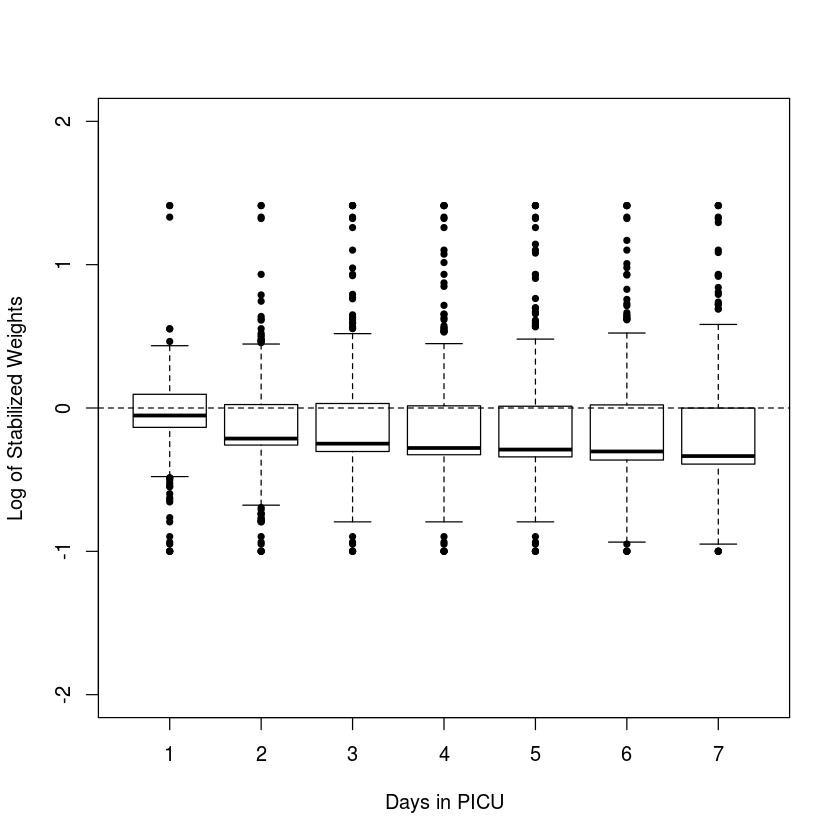

In [16]:
# stabilized weights for MSM Cox PH model for 7 days
time_model <- ipwtm(
  exposure = HFV_indicator,
  family = "survival",
  numerator = ~1,
  denominator = ~ age+pim2+pelod+factor(female)+factor(p_bloodculture)+factor(comorbidity)+factor(rf_pneumonia)+factor(rf_sepsis)
                 +factor(rf_aspiration)+factor(rf_transfusion)+factor(rf_drowning)+factor(MODS)+factor(OI_cat),
  
  id = ID,
  tstart = start_day,
  timevar = end_day,
  type = "first",
  data = df3, trunc=0.01)
summary(time_model$weights.trunc)


######################plot (stabilized) inverse probability weights######################

#tiff("sw_plot.tiff", width = 4, height = 4,  units = 'in', res = 300)
#png(filename="sw_plot.png")
ipwplot(weights = time_model$weights.trunc, timevar = df2$end_day, xlab="Days in PICU", ylab="Log of Stabilized Weights",
   binwidth = 1, ylim=c(-2,2))
#dev.off()

#MSM Cox PH model with adjustment for covariates
# MSM<-coxph(Surv(start_day, end_day, event_7) ~ HFV_indicator+factor(female)+pim2+pelod+factor(p_bloodculture)+factor(comorbidity)
#            +factor(rf_pneumonia)+factor(rf_sepsis)+factor(rf_aspiration)+factor(rf_transfusion)+factor(rf_drowning)+factor(MODS)
#            +factor(OI_cat)+cluster(ID)+age:end_day+pim2:end_day+pelod:end_day, data = df3, weights = time_model$weights.trunc)

MSM<-coxph(Surv(start_day, end_day, event) ~ HFV_indicator+factor(female)+age+pim2+pelod+factor(p_bloodculture) +factor(MODS)+factor(comorbidity)
           +cluster(ID), data = df3, weights = time_model$weights.trunc)

summary(MSM)

fit0<-cox.zph(MSM, global=TRUE)
cox.zph(MSM, global=TRUE)

In [14]:
###### Check for PH assumption of MSM
#####      redisual plots for MSM

time_model <- ipwtm(
  exposure = HFV_indicator,
  family = "survival",

  numerator = ~ female+age+pim2+pelod+p_bloodculture+comorbidity+rf_pneumonia+rf_sepsis
                 +rf_aspiration+rf_transfusion+rf_drowning+MODS+factor(OI_cat),
  denominator = ~1,
  id = ID,
  tstart = start_day,
  timevar = end_day,
  type = "first",
  data = df2, trunc=0.01)


#MSM Cox PH model with adjustment for covariates
MSM<-coxph(Surv(start_day, end_day, event) ~ HFV_indicator+female+age+pim2+pelod+p_bloodculture+comorbidity+rf_pneumonia+rf_sepsis
                 +rf_aspiration+rf_transfusion+rf_drowning+MODS+factor(OI_cat)+cluster(ID)+age:end_day+comorbidity:end_day+pelod:end_day,
   data = df2, weights = time_model$weights.trunc)


fit0<-cox.zph(MSM, global=TRUE)
cox.zph(MSM, global=TRUE)

vars<-c("HFOV","Gender(Female)","Age","PIM2","PELOD","Bacteremia","Comorbidity","Pneumonia Risk","Sepsis Risk","Aspiration Risk",
        "Transfusion Risk","Drowning Risk","Multiorgan dysfunction","Oxygenation index","Cat2","Cat3","Age:Time","Comorbidity:Time","PELOD:Time")


png("rplot0.png",width = 600, height = 600)
p1<-plot(fit0, ylab=vars, var=1,col="red")
dev.off()


png("rplot1.png",width = 600, height = 600)
layout(matrix(c(1,2,3,4), 2, 2, byrow = TRUE), 
   widths=c(1,1,1,1), heights=c(1,1,1,1))
#p1<-plot(fit0, ylab=vars, var=1,col="red")

p2<-plot(fit0, ylab=vars, var=2,col="red")
p3<-plot(fit0, ylab=vars, var=3,col="red")
p4<-plot(fit0, ylab=vars, var=4,col="red")
p5<-plot(fit0, ylab=vars, var=5,col="red")
dev.off()
png("rplot2.png",width = 600, height = 600)
layout(matrix(c(1,2,3,4), 2, 2, byrow = TRUE), 
   widths=c(1,1,1,1), heights=c(1,1,1,1))
p6<-plot(fit0, ylab=vars, var=6,col="red")
p7<-plot(fit0, ylab=vars, var=7,col="red")
p8<-plot(fit0, ylab=vars, var=8,col="red")
p9<-plot(fit0, ylab=vars, var=9,col="red")
dev.off()
png("rplot3.png",width = 600, height = 600)
layout(matrix(c(1,2,3,4), 2, 2, byrow = TRUE), 
   widths=c(1,1,1,1), heights=c(1,1,1,1))
p10<-plot(fit0, ylab=vars, var=10,col="red")
p11<-plot(fit0, ylab=vars, var=11,col="red")
p12<-plot(fit0, ylab=vars, var=12,col="red")
p13<-plot(fit0, ylab=vars, var=13,col="red")
dev.off()
png("rplot4.png",width = 600, height = 600)
layout(matrix(c(1,2,3,4), 2, 2, byrow = TRUE), 
   widths=c(1,1,1,1), heights=c(1,1,1,1))
p14<-plot(fit0, ylab=vars, var=14,col="red")
#p15<-plot(fit0, ylab=vars, var=15,col="red")
#p16<-plot(fit0, ylab=vars, var=16,col="red")
p17<-plot(fit0, ylab=vars, var=17,col="red")
p18<-plot(fit0, ylab=vars, var=18,col="red")
p19<-plot(fit0, ylab=vars, var=19,col="red")
dev.off()

Warning message in fitter(X, Y, strats, offset, init, control, weights = weights, :
“Loglik converged before variable  11 ; beta may be infinite. ”

                         rho    chisq        p
HFV_indicator        0.17065 3.56e+00 5.91e-02
female              -0.11480 3.52e+00 6.08e-02
age                  0.09304 8.66e-01 3.52e-01
pim2                -0.19556 9.08e+00 2.59e-03
pelod                0.02630 8.91e-02 7.65e-01
p_bloodculture      -0.12243 1.38e+00 2.40e-01
comorbidity         -0.08322 1.20e+00 2.74e-01
rf_pneumonia         0.22290 1.42e+01 1.67e-04
rf_sepsis            0.01670 2.13e-02 8.84e-01
rf_aspiration       -0.18491 8.33e+00 3.90e-03
rf_transfusion      -0.21963 4.03e+00 4.47e-02
rf_drowning         -0.01107 8.38e-03 9.27e-01
MODS                 0.22079 1.89e+01 1.40e-05
factor(OI_cat)2      0.04033 1.16e-01 7.33e-01
factor(OI_cat)3     -0.22963 1.25e+01 4.05e-04
factor(OI_cat)4     -0.36164 1.79e+01 2.35e-05
age:end_day         -0.15472 2.51e+00 1.13e-01
comorbidity:end_day  0.07478 1.01e+00 3.15e-01
pelod:end_day       -0.00226 7.01e-04 9.79e-01
GLOBAL                    NA 5.03e+01 1.19e-04

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

## PSM on a daily basis

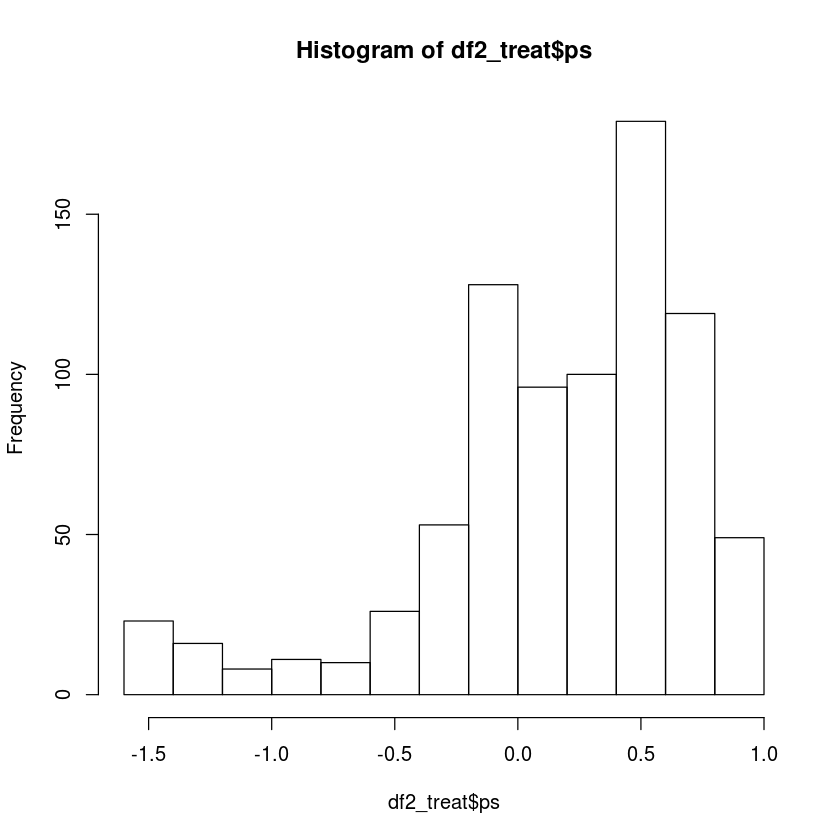

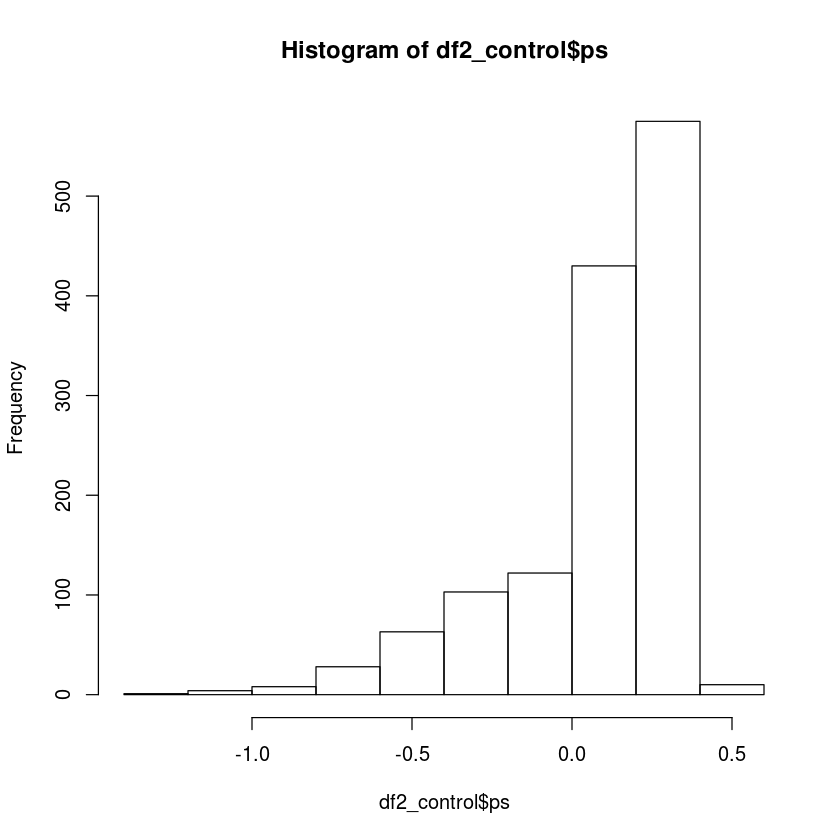

In [17]:
df2$weight_trunc<-time_model$weights.trunc
####################################################
#Alternative Method: PS matching on a daily basis
####################################################

########## Prepare Dataset for matching ####################
df2_treat<-df2[df2$treatment==1,]
df2_control<-df2[df2$treatment==0,]

df2_treat$ps<-log(1/df2_treat$weight_trunc)
hist(df2_treat$ps)

df2_control$ps<-log(1/df2_control$weight_trunc)
hist(df2_control$ps)



In [ ]:
# ########### Match for Day 2 hfov ####################
# treat_day<-df2_treat[df2_treat$end_day==2 & df2_treat$HFV_indicator==1 & !(df2_treat$ID %in% pairs_total$matchedID_hfv),]
# control_day<-df2_control[df2_control$end_day==2 & !(df2_control$ID %in% pairs_total$matchedID_non_hfv),]
# #nrow(treat_day)
# #nrow(control_day)
# df_day2<-rbind(treat_day,control_day)
# #nrow(df_day2)

# m.out <- matchit(treatment~age+pim2+pelod+factor(female)+factor(p_bloodculture)+factor(comorbidity)+factor(MODS)+factor(OI_cat), data = df_day2,              
#                  method = "nearest",
#                  distance="linear.logit",
#                  discard="both",
#                  m.order="smallest",
#                  calclosest=TRUE)
# #summary(m.out)
# matchedID_hfv<-match.data(m.out, "treat")$ID
# matchedID_non_hfv<-match.data(m.out, "control")$ID
# pairs<-data.frame(cbind(matchedID_hfv,matchedID_non_hfv))
# pairs_total<-rbind(pairs_total, pairs)

# #write.csv(pairs, file = "pair_ID.csv")
# nrow(pairs)
# #nrow(pairs_total)

# ########## Match for Day 3 hfov ####################

# treat_day<-df2_treat[df2_treat$end_day==3 & df2_treat$HFV_indicator==1 & !(df2_treat$ID %in% pairs_total$matchedID_hfv),]
# control_day<-df2_control[df2_control$end_day==3 & !(df2_control$ID %in% pairs_total$matchedID_non_hfv),]
# #nrow(treat_day)
# #nrow(control_day)
# df_day3<-rbind(treat_day,control_day)
# #nrow(df_day3)

# m.out <- matchit(treatment~age+pim2+pelod+factor(female)+factor(p_bloodculture)+factor(comorbidity)+factor(rf_pneumonia)+factor(rf_sepsis)
#                  +factor(rf_aspiration)
#                  #+factor(rf_transfusion)
#                  +factor(rf_drowning)+factor(MODS)+factor(OI_cat), data = df_day3,              
#                  method = "nearest",
#                  distance="linear.logit",
#                  discard="both",
#                  m.order="smallest",
#                  calclosest=TRUE)
# #summary(m.out)
# matchedID_hfv<-match.data(m.out, "treat")$ID
# matchedID_non_hfv<-match.data(m.out, "control")$ID
# pairs<-data.frame(cbind(matchedID_hfv,matchedID_non_hfv))
# pairs_total<-rbind(pairs_total, pairs)


# nrow(pairs)
# #nrow(pairs_total)

# ########## Match for Day 4 hfov ####################

# treat_day<-df2_treat[df2_treat$end_day==4 & df2_treat$HFV_indicator==1 & !(df2_treat$ID %in% pairs_total$matchedID_hfv),]
# control_day<-df2_control[df2_control$end_day==4 & !(df2_control$ID %in% pairs_total$matchedID_non_hfv),]
# #nrow(treat_day)
# #nrow(control_day)
# df_day4<-rbind(treat_day,control_day)
# #nrow(df_day4)

# m.out <- matchit(treatment~age+pim2+pelod+factor(female)+factor(p_bloodculture)+factor(comorbidity)+factor(rf_pneumonia)+factor(rf_sepsis)
#                  +factor(rf_aspiration)
#                  #+factor(rf_transfusion)
#                  +factor(rf_drowning)+factor(MODS)+factor(OI_cat),  data = df_day4,              
#                  method = "nearest",
#                  distance="linear.logit",
#                  discard="both",
#                  m.order="smallest",
#                  calclosest=TRUE)
# #summary(m.out)
# matchedID_hfv<-match.data(m.out, "treat")$ID
# matchedID_non_hfv<-match.data(m.out, "control")$ID
# pairs<-data.frame(cbind(matchedID_hfv,matchedID_non_hfv))
# pairs_total<-rbind(pairs_total, pairs)


# nrow(pairs)
# #nrow(pairs_total)

# ########## Match for Day 5 hfov ####################

# treat_day<-df2_treat[df2_treat$end_day==5 & df2_treat$HFV_indicator==1 & !(df2_treat$ID %in% pairs_total$matchedID_hfv),]
# control_day<-df2_control[df2_control$end_day==5 & !(df2_control$ID %in% pairs_total$matchedID_non_hfv),]
# #nrow(treat_day)
# #nrow(control_day)
# df_day5<-rbind(treat_day,control_day)
# #nrow(df_day5)

# m.out <- matchit(treatment~age+pim2+pelod+factor(female)+factor(p_bloodculture)+factor(comorbidity)+factor(rf_pneumonia)+factor(rf_sepsis)
#                  +factor(rf_aspiration)
#                  #+factor(rf_transfusion)
#                  +factor(rf_drowning)+factor(MODS)+factor(OI_cat),  data = df_day5,              
#                  method = "nearest",
#                  distance="linear.logit",
#                  discard="both",
#                  m.order="smallest",
#                  calclosest=TRUE)
# #summary(m.out)
# matchedID_hfv<-match.data(m.out, "treat")$ID
# matchedID_non_hfv<-match.data(m.out, "control")$ID
# pairs<-data.frame(cbind(matchedID_hfv,matchedID_non_hfv))
# pairs_total<-rbind(pairs_total, pairs)


# nrow(pairs)
# #nrow(pairs_total)

# ########### Match for Day 6 hfov ####################
# treat_day<-df2_treat[df2_treat$end_day==6 & df2_treat$HFV_indicator==1 & !(df2_treat$ID %in% pairs_total$matchedID_hfv),]
# control_day<-df2_control[df2_control$end_day==6 & !(df2_control$ID %in% pairs_total$matchedID_non_hfv),]
# #nrow(treat_day)
# #nrow(control_day)
# df_day6<-rbind(treat_day,control_day)
# #nrow(df_day6)

# m.out <- matchit(treatment~age+pim2+pelod+factor(female)+factor(p_bloodculture)+factor(comorbidity)+factor(rf_pneumonia)+factor(rf_sepsis)
#                  +factor(rf_aspiration)
#                  #+factor(rf_transfusion)
#                  +factor(rf_drowning)+factor(MODS)+factor(OI_cat), data = df_day6,              
#                  method = "nearest",
#                  distance="linear.logit",
#                  discard="both",
#                  m.order="smallest",
#                  calclosest=TRUE)
# #summary(m.out)
# matchedID_hfv<-match.data(m.out, "treat")$ID
# matchedID_non_hfv<-match.data(m.out, "control")$ID
# pairs<-data.frame(cbind(matchedID_hfv,matchedID_non_hfv))
# pairs_total<-rbind(pairs_total, pairs)

# #write.csv(pairs, file = "pair_ID.csv")
# nrow(pairs)
# #nrow(pairs_total)

# ########## Match for Day 7 hfov ####################
# treat_day<-df2_treat[df2_treat$end_day==7 & df2_treat$HFV_indicator==1 & !(df2_treat$ID %in% pairs_total$matchedID_hfv),]
# control_day<-df2_control[df2_control$end_day==7 & !(df2_control$ID %in% pairs_total$matchedID_non_hfv),]
# #nrow(treat_day)
# #nrow(control_day)
# df_day7<-rbind(treat_day,control_day)
# #nrow(df_day7)

# m.out <- matchit(treatment~age+pim2+pelod+factor(female)+factor(p_bloodculture)+factor(comorbidity)+factor(rf_pneumonia)+factor(rf_sepsis)
#                  +factor(rf_aspiration)
#                  #+factor(rf_transfusion)
#                  +factor(rf_drowning)+factor(MODS)+factor(OI_cat),  data = df_day7,              
#                  method = "nearest",
#                  distance="linear.logit",
#                  discard="both",
#                  m.order="smallest",
#                  calclosest=TRUE)
# #summary(m.out)
# matchedID_hfv<-match.data(m.out, "treat")$ID
# matchedID_non_hfv<-match.data(m.out, "control")$ID
# pairs<-data.frame(cbind(matchedID_hfv,matchedID_non_hfv))
# pairs_total<-rbind(pairs_total, pairs)


# nrow(pairs)
# nrow(pairs_total)


# ####################################################
# #Alternative Method: PS matching on a daily basis
# ####################################################

# ########## Outcome analysis for daily pairs ####################

# #daily_pair_ID <- read.csv("daily_pair_ID.csv")
# daily_pair_ID<- pairs_total
# mydata$mort_100day<-ifelse(kkh$Died.within.100.days=="Yes",1,0)
# sensitivity_data<-mydata[(mydata$ID %in% daily_pair_ID$matchedID_hfv)| (mydata$ID %in% daily_pair_ID$matchedID_non_hfv),]
# head(sensitivity_data)
# pair_number<-length(sensitivity_data[,1])

# #pairwise difference for continuous data
# hfv<-sensitivity_data[sensitivity_data$ID %in% daily_pair_ID$matchedID_hfv,]
# non_hfv<-sensitivity_data[sensitivity_data$ID %in% daily_pair_ID$matchedID_non_hfv,]




# #paired t-test for ventilator free days
# print("paired t-test for ventilator free days difference between HFOV less Non-HFOV")
# diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
# t.test(diffy)

# #paired t-test for picu free days
# print("paired t-test for picu free days difference between HFOV less Non-HFOV")
# diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
# t.test(diffy1)

# #McNemar test for 100 day mortality
# print("100 day mortality difference between HFOV less Non-HFOV")
# mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

# #calculate n% of 100 day mortality for matched cohort
# print("Non-HFOV group 100day mortality n:")
# length(non_hfv$ID[non_hfv$mort_100day==1])
# print("%:")
# length(non_hfv$ID[non_hfv$mort_100day==1])/pair_number
# print("HFOV group 100day mortality n:")
# length(hfv$ID[hfv$mort_100day==1])
# print("%:")
# length(hfv$ID[hfv$mort_100day==1])/pair_number

# #McNemar test for 28-day mortality
# y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
# y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
# table(y_treatment,y_control)
# print("28 day mortality difference between HFOV less Non-HFOV")
# mcnemar.test(y_treatment, y_control)

# #calculate odds ratio for 28-day mortality
# y_treatment<-sensitivity_data$mortality_28day[sensitivity_data$treatment==1] 
# y_control<-sensitivity_data$mortality_28day[sensitivity_data$treatment==0] 

# ########## calculate Odd's ratio here!
# print("Odds ratio")
# a<-length(y_treatment[y_treatment==1])
# b<-length(y_control[y_control==1])
# c<-length(y_treatment[y_treatment==0])
# d<-length(y_control[y_control==0])
# print(c(a,b,c,d))
# a/(a+c)
# b/(b+d)

# oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))


In [18]:

####################################################
#Alternative Method: PS matching on a daily basis
####################################################

########## Outcome analysis for daily pairs ####################

daily_pair_ID <- read.csv("daily_pair_ID.csv")

mydata$mort_100day<-ifelse(kkh$Died.within.100.days=="Yes",1,0)
sensitivity_data<-mydata[(mydata$ID %in% daily_pair_ID$matchedID_hfv)| (mydata$ID %in% daily_pair_ID$matchedID_non_hfv),]
head(sensitivity_data)
pair_number<-length(sensitivity_data[,1])

#pairwise difference for continuous data
hfv<-sensitivity_data[sensitivity_data$ID %in% daily_pair_ID$matchedID_hfv,]
non_hfv<-sensitivity_data[sensitivity_data$ID %in% daily_pair_ID$matchedID_non_hfv,]




#paired t-test for ventilator free days
print("paired t-test for ventilator free days difference between HFOV less Non-HFOV")
diffy<-hfv$ventilation_free_day-non_hfv$ventilation_free_day
t.test(diffy)

#paired t-test for picu free days
print("paired t-test for picu free days difference between HFOV less Non-HFOV")
diffy1<-hfv$picu_free_days-non_hfv$picu_free_days
t.test(diffy1)

#McNemar test for 100 day mortality
print("100 day mortality difference between HFOV less Non-HFOV")
mcnemar.test(hfv$mort_100day, non_hfv$mort_100day)

#calculate n% of 100 day mortality for matched cohort
print("Non-HFOV group 100day mortality n:")
length(non_hfv$ID[non_hfv$mort_100day==1])
print("%:")
length(non_hfv$ID[non_hfv$mort_100day==1])/pair_number
print("HFOV group 100day mortality n:")
length(hfv$ID[hfv$mort_100day==1])
print("%:")
length(hfv$ID[hfv$mort_100day==1])/pair_number

#McNemar test for 28-day mortality
y_treatment<-hfv$mortality_28day[hfv$treatment==1] 
y_control<-non_hfv$mortality_28day[non_hfv$treatment==0] 
table(y_treatment,y_control)
print("28 day mortality difference between HFOV less Non-HFOV")
mcnemar.test(y_treatment, y_control)

#calculate odds ratio for 28-day mortality
y_treatment<-sensitivity_data$mortality_28day[sensitivity_data$treatment==1] 
y_control<-sensitivity_data$mortality_28day[sensitivity_data$treatment==0] 

########## calculate Odd's ratio here!
print("Odds ratio")
a<-length(y_treatment[y_treatment==1])
b<-length(y_control[y_control==1])
c<-length(y_treatment[y_treatment==0])
d<-length(y_control[y_control==0])
print(c(a,b,c,d))
a/(a+c)
b/(b+d)

oddsratio(matrix(c(a,b,c,d), ncol=2, nrow=2))

,ID,hospital_number,female,age,pim2,pelod,p_bloodculture,comorbidity,rf_pneumonia,rf_sepsis,⋯,mortality_100day,ventilation_free_day,picu_free_days,fio2,map,amplitude,OI_cat,ICUduration,mort_100day,weight
3,1005,1,1,0.10,0.6,1,0,0,1,0,⋯,0,21,20,NA,NA,NA,2,9,0,1.692353
10,1014,1,1,5.08,18.2,3,0,0,1,1,⋯,1,0,0,NA,NA,NA,1,62,1,1.050604
11,1015,1,1,5.08,18.2,3,1,0,1,1,⋯,1,0,0,NA,NA,NA,4,62,1,2.638227
16,1020,1,0,2.78,41.8,21,0,0,0,0,⋯,0,24,23,NA,NA,NA,1,6,0,1.068845
18,1022,1,1,0.28,9.0,20,0,1,1,0,⋯,0,16,15,58.75,28,50,2,14,0,1.757998
27,1037,1,1,0.28,8.9,20,0,1,1,0,⋯,0,16,15,67.00,28,53,2,14,0,1.758396


[1] "paired t-test for ventilator free days difference between HFOV less Non-HFOV"



	One Sample t-test

data:  diffy
t = -2.4547, df = 38, p-value = 0.01879
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -9.5913158 -0.9215048
sample estimates:
mean of x 
 -5.25641 


[1] "paired t-test for picu free days difference between HFOV less Non-HFOV"



	One Sample t-test

data:  diffy1
t = -1.9139, df = 38, p-value = 0.06318
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -7.3866771  0.2071899
sample estimates:
mean of x 
-3.589744 


[1] "100 day mortality difference between HFOV less Non-HFOV"



	McNemar's Chi-squared test with continuity correction

data:  hfv$mort_100day and non_hfv$mort_100day
McNemar's chi-squared = 0.94118, df = 1, p-value = 0.332


[1] "Non-HFOV group 100day mortality n:"


[1] 9

[1] "%:"


[1] 0.1153846

[1] "HFOV group 100day mortality n:"


[1] 14

[1] "%:"


[1] 0.1794872

           y_control
y_treatment  0  1
          0 25  5
          1  7  2

[1] "28 day mortality difference between HFOV less Non-HFOV"



	McNemar's Chi-squared test with continuity correction

data:  y_treatment and y_control
McNemar's chi-squared = 0.083333, df = 1, p-value = 0.7728


[1] "Odds ratio"
[1]  9  7 30 32


[1] 0.2307692

[1] 0.1794872

,Disease1,Disease2,Total
Exposed1,9,30,39
Exposed2,7,32,39
Total,16,62,78
,estimate,lower,upper
Exposed1,1.000000,NA,NA
Exposed2,1.360465,0.4434294,4.331214
,midp.exact,fisher.exact,chi.square
Exposed1,NA,NA,NA
Exposed2,0.5903969,0.7799148,0.574922


## multi-center effects

In [19]:
################################################################################
### Stratified Cox model with interaction terms to study the multi-center effects
################################################################################
Strata_cox_model<-coxph(Surv(mortality_28day)~treatment+treatment:factor(hospital_number)+female+age+pim2+pelod+p_bloodculture+comorbidity+rf_pneumonia+rf_sepsis
                 +rf_aspiration+rf_transfusion+rf_drowning+MODS+factor(OI_cat)+strata(hospital_number), data=mydata)
summary(Strata_cox_model)
cox.zph(Strata_cox_model, global=TRUE)

Call:
coxph(formula = Surv(mortality_28day) ~ treatment + treatment:factor(hospital_number) + 
    female + age + pim2 + pelod + p_bloodculture + comorbidity + 
    rf_pneumonia + rf_sepsis + rf_aspiration + rf_transfusion + 
    rf_drowning + MODS + factor(OI_cat) + strata(hospital_number), 
    data = mydata)

  n= 328, number of events= 328 

                                         coef exp(coef)  se(coef)      z
treatment                           -0.303536  0.738204  0.270010 -1.124
female                              -0.082235  0.921056  0.126627 -0.649
age                                 -0.001981  0.998021  0.013980 -0.142
pim2                                -0.002125  0.997877  0.003991 -0.533
pelod                               -0.009811  0.990237  0.007837 -1.252
p_bloodculture                      -0.277258  0.757859  0.187753 -1.477
comorbidity                         -0.135601  0.873191  0.145430 -0.932
rf_pneumonia                         0.026487  1.026841  0.206589  0

                                          rho    chisq     p
treatment                           -0.006496 1.55e-02 0.901
female                               0.029285 3.29e-01 0.566
age                                 -0.012622 5.34e-02 0.817
pim2                                -0.000180 1.15e-05 0.997
pelod                                0.055480 1.05e+00 0.307
p_bloodculture                       0.034915 4.80e-01 0.488
comorbidity                          0.018367 1.25e-01 0.724
rf_pneumonia                         0.001628 9.48e-04 0.975
rf_sepsis                           -0.003312 4.30e-03 0.948
rf_aspiration                       -0.009059 2.86e-02 0.866
rf_transfusion                       0.005168 9.02e-03 0.924
rf_drowning                         -0.009832 3.45e-02 0.853
MODS                                 0.055718 1.03e+00 0.311
factor(OI_cat)2                     -0.036873 4.70e-01 0.493
factor(OI_cat)3                     -0.002379 2.00e-03 0.964
factor(OI_cat)4         

## Calculate HOFV and CMV setting for the original cohort

In [20]:
hfov_setting<-data.frame(mydata[mydata$treatment==1,c("fio2","map","amplitude")])

head(hfov_setting)
colMeans(hfov_setting[,c("map","amplitude","fio2")], na.rm=TRUE)

map<-subset(hfov_setting$map, (!is.na(hfov_setting[,"map"])))
amplitude<-subset(hfov_setting$amplitude, (!is.na(hfov_setting[,"amplitude"])))
fio2<-subset(hfov_setting$fio2, (!is.na(hfov_setting[,"fio2"])))

sd(map) 
sd(amplitude) 
sd(fio2) 

,fio2,map,amplitude
4,100.00,23.0,70.00000
6,100.00,32.0,43.66667
8,100.00,30.0,75.00000
15,71.00,30.0,55.80000
18,58.75,28.0,50.00000
20,100.00,25.5,62.00000


map amplitude      fio2 
 24.92240  55.21475  82.93145

[1] 5.653893

[1] 13.84455

[1] 17.89838

In [21]:
cmv_data <- read.csv("cmv_data_1125.csv")
head(cmv_data)

StudyID,D1_HFV,D2_HFV,D3_HFV,D4_HFV,D5_HFV,D6_HFV,D7_HFV,HFOV_days,exclude,⋯,d3_amplitude,d4_amplitude,d5_amplitude,d6_amplitude,d7_amplitude,cmv_tidal,cmv_fio2,cmv_pip,cmv_peep,cmv_map
1001,0,0,0,0,0,0,0,0,include,⋯,0,0,0,0,0,19.00000,65.00000,25.00000,9.000000,14.50000
1003,0,0,0,0,0,0,0,0,include,⋯,0,0,0,0,0,83.50000,28.57143,15.50000,3.714286,13.06667
1005,0,0,0,0,0,0,0,0,include,⋯,0,0,0,0,0,44.71429,33.57143,22.28572,1.000000,18.00000
1008,0,0,0,0,0,0,0,0,include,⋯,0,0,0,0,0,231.50000,34.00000,15.25000,6.000000,20.00000
1010,0,0,0,0,0,0,0,0,include,⋯,0,0,0,0,0,26.75000,42.80000,17.50000,7.200000,12.00000
1012,0,0,0,0,0,0,0,0,include,⋯,0,0,0,0,0,51.20000,31.83333,19.00000,6.833333,10.48000


In [22]:
#colnames(cmv_data)
cmv<-cmv_data[,c("cmv_tidal","cmv_fio2","cmv_pip","cmv_peep","cmv_map","D2_ventilation_mode","Weight_kg")]
unique(cmv$D2_ventilation_mode)
cmv_setting<-cmv[cmv$D2_ventilation_mode=="Pressure controlled ventilation" |cmv$D2_ventilation_mode=="Volume controlled ventilation"  ,]
aprv_setting<-cmv[cmv$D2_ventilation_mode=="Airway pressure release ventilation" ,]

[1] Pressure controlled ventilation     Airway pressure release ventilation
[3] Volume controlled ventilation      
3 Levels: Airway pressure release ventilation ...

In [23]:
aprv_setting$cmv_tidal_kg<- aprv_setting$cmv_tidal/aprv_setting$Weight_kg
head(aprv_setting)

,cmv_tidal,cmv_fio2,cmv_pip,cmv_peep,cmv_map,D2_ventilation_mode,Weight_kg,cmv_tidal_kg
2,83.50000,28.57143,15.50000,3.714286,13.06667,Airway pressure release ventilation,8.80,9.488636
3,44.71429,33.57143,22.28572,1.000000,18.00000,Airway pressure release ventilation,4.69,9.533963
4,231.50000,34.00000,15.25000,6.000000,20.00000,Airway pressure release ventilation,42.00,5.511905
7,257.71429,40.14286,20.42857,1.428571,18.28572,Airway pressure release ventilation,19.00,13.563910
8,258.71429,58.57143,30.00000,0.000000,27.42857,Airway pressure release ventilation,19.00,13.616542
9,225.00000,70.00000,29.33333,2.000000,25.16667,Airway pressure release ventilation,19.00,11.842105


In [24]:
#APRV setting
colMeans(aprv_setting[,c("cmv_tidal_kg","cmv_fio2","cmv_pip","cmv_peep","cmv_map")], na.rm=TRUE)
apply(aprv_setting[,c("cmv_tidal_kg","cmv_fio2","cmv_pip","cmv_peep","cmv_map")], 2, sd, na.rm = TRUE)

cmv_tidal_kg     cmv_fio2      cmv_pip     cmv_peep      cmv_map 
  10.0669426   61.0319397   25.9035423    0.9996516   23.2675958

cmv_tidal_kg     cmv_fio2      cmv_pip     cmv_peep      cmv_map 
    3.307655    23.087932     6.621943     1.961925     6.092872

In [25]:
#CMV setting
cmv_setting$cmv_tidal_kg<- cmv_setting$cmv_tidal/cmv_setting$Weight_kg
head(cmv_setting)

,cmv_tidal,cmv_fio2,cmv_pip,cmv_peep,cmv_map,D2_ventilation_mode,Weight_kg,cmv_tidal_kg
1,19.00000,65.00000,25.00000,9.000000,14.50000,Pressure controlled ventilation,2.5,7.600000
5,26.75000,42.80000,17.50000,7.200000,12.00000,Pressure controlled ventilation,2.7,9.907407
6,51.20000,31.83333,19.00000,6.833333,10.48000,Pressure controlled ventilation,4.2,12.190476
10,350.00000,41.50000,24.00000,9.333333,15.00000,Pressure controlled ventilation,30.0,11.666667
11,40.71429,35.00000,20.14286,6.857143,12.14286,Pressure controlled ventilation,2.6,15.659341
12,120.00000,40.16667,23.00000,7.400000,13.66000,Volume controlled ventilation,12.0,10.000000


In [26]:
#CMV setting
colMeans(cmv_setting[,c("cmv_tidal_kg","cmv_fio2","cmv_pip","cmv_peep","cmv_map")], na.rm=TRUE)
apply(cmv_setting[,c("cmv_tidal_kg","cmv_fio2","cmv_pip","cmv_peep","cmv_map")], 2, sd, na.rm = TRUE)

cmv_tidal_kg     cmv_fio2      cmv_pip     cmv_peep      cmv_map 
    3.664655    55.288528    20.578413     5.995657    11.877597

cmv_tidal_kg     cmv_fio2      cmv_pip     cmv_peep      cmv_map 
    4.659101    19.182030    10.109051     3.382720     7.022301

In [27]:
p_map<-ggplot(data=hfov_setting, aes(hfov_setting$map,..density..))+
        geom_histogram(color="black", fill="lightblue", bins=6)+xlab("MAP")+ylab("Probability Density")+
        theme_bw(base_size = 16)+
         theme(plot.background = element_blank(),#axis.title.y=element_blank(),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank() )+
         theme(panel.border= element_blank())+
         theme(axis.line.x = element_line(color="black", size = 0.5),axis.line.y = element_line(color="black", size = 0.5))

p_fio2<-ggplot(data=hfov_setting, aes(hfov_setting$fio2,..density..))+ylim(0, 0.04)+
        geom_histogram(color="black", fill="lightblue", bins=6)+xlab("FiO2")+
        theme_bw(base_size = 16)+
        theme(plot.background = element_blank(),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank(),axis.title.y=element_blank())+

         theme(panel.border= element_blank())+
         theme(axis.line.x = element_line(color="black", size = 0.5),axis.line.y = element_line(color="black", size = 0.5))
p_amplitue<-ggplot(data=hfov_setting, aes(hfov_setting$amplitude,..density..))+ylim(0, 0.04)+
        geom_histogram(color="black", fill="lightblue", bins=6)+xlab("Amplitude")+
        theme_bw(base_size = 16)+
        theme(plot.background = element_blank(),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank(),axis.title.y=element_blank())+theme(panel.border= element_blank())+
         theme(axis.line.x = element_line(color="black", size = 0.5),axis.line.y = element_line(color="black", size = 0.5))



In [28]:
p_map<-ggplot(data=hfv, aes(hfv$map,..density..))+
        geom_histogram(color="black", fill="lightblue", bins=6)+xlab("MAP")+
        theme_bw(base_size = 16)+
         theme(plot.background = element_blank(),axis.title.y=element_blank(),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank() )+
         theme(panel.border= element_blank())+
         theme(axis.line.x = element_line(color="black", size = 0.5),axis.line.y = element_line(color="black", size = 0.5))

p_fio2<-ggplot(data=hfv, aes(hfv$fio2,..density..))+ylim(0, 0.04)+
        geom_histogram(color="black", fill="lightblue", bins=6)+xlab("FiO2")+
        theme_bw(base_size = 16)+
        theme(plot.background = element_blank(),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank(),axis.title.y=element_blank())+

         theme(panel.border= element_blank())+
         theme(axis.line.x = element_line(color="black", size = 0.5),axis.line.y = element_line(color="black", size = 0.5))
p_amplitue<-ggplot(data=hfv, aes(hfv$amplitude,..density..))+ylim(0, 0.04)+
        geom_histogram(color="black", fill="lightblue", bins=6)+xlab("Amplitude")+
        theme_bw(base_size = 16)+
        theme(plot.background = element_blank(),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank(),axis.title.y=element_blank() )+
         theme(panel.border= element_blank())+
         theme(axis.line.x = element_line(color="black", size = 0.5),axis.line.y = element_line(color="black", size = 0.5))



Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing non-finite values (stat_bin).”

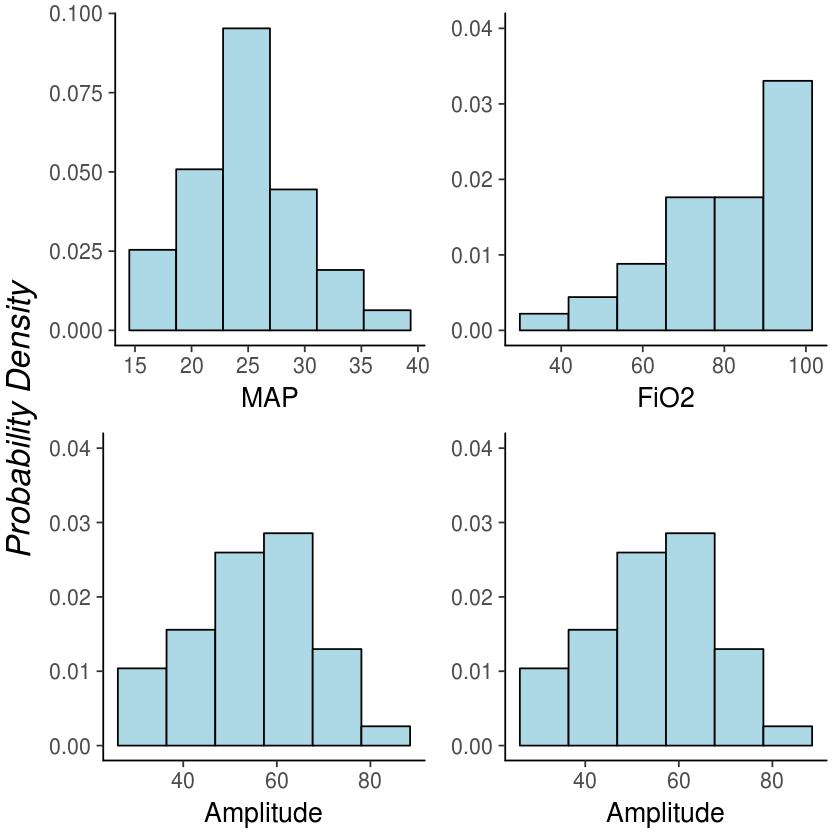

In [29]:

grid.arrange(p_map,p_fio2, p_amplitue,p_amplitue, ncol=2,
             left=textGrob("Probability Density",gp=gpar(fontsize=20,font=3),rot=90))
